In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from collections import Counter
import warnings

# Imports cho Hồi quy (1.4a)
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.base import clone

# Imports cho Tiền xử lý, Giảm chiều, Phân cụm (1.1, 1.2, 1.3)
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score


# Imports cho Phân loại (1.4c)
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.neighbors import KNeighborsClassifier

## 1.1. Tiền Xử Lý Dữ Liệu
### Đọc, Mô Tả và Chuẩn Hóa Dữ Liệu 

Thực hiện các bước tiền xử lý dữ liệu theo yêu cầu: đọc dữ liệu, mô tả cấu trúc, xử lý dữ liệu lỗi, chuyển đổi categorical và chuẩn hóa giá trị.

In [29]:
# Thiết lập đường dẫn
BASE_DIR = os.path.abspath('..')
PROCESSED_DIR = os.path.join(BASE_DIR, "data", "processed")
ENHANCED_DATA_FILE = os.path.join(PROCESSED_DIR, "enhanced_car_data.csv")
MODEL_DIR = os.path.join(PROCESSED_DIR, "models")
os.makedirs(MODEL_DIR, exist_ok=True)

print(f" Thư mục gốc: {BASE_DIR}")
print(f" File dữ liệu: {ENHANCED_DATA_FILE}")
print(f" Thư mục mô hình: {MODEL_DIR}")

# Tải dữ liệu xe được tăng cường
print("\nĐang tải dữ liệu xe được tăng cường...")
df = pd.read_csv(ENHANCED_DATA_FILE)

print(f" Tải dữ liệu thành công!")
print(f" Kích thước dataset: {df.shape}")
print(f" Các cột: {list(df.columns)}")

# Hiển thị thông tin cơ bản
print(f"\n Tổng quan dữ liệu:")
print(f"- Tổng số mẫu: {len(df):,}")
print(f"- Tổng số đặc trưng: {len(df.columns)}")
print(f"- Giá trị thiếu: {df.isnull().sum().sum()}")

df.head()

 Thư mục gốc: d:\hocmaypush\MachineLearning
 File dữ liệu: d:\hocmaypush\MachineLearning\data\processed\enhanced_car_data.csv
 Thư mục mô hình: d:\hocmaypush\MachineLearning\data\processed\models

Đang tải dữ liệu xe được tăng cường...
 Tải dữ liệu thành công!
 Kích thước dataset: (13453, 20)
 Các cột: ['url', 'name', 'brand', 'price', 'price_million', 'year', 'car_age', 'origin', 'transmission', 'body_type', 'engine', 'fuel_type', 'engine_capacity', 'drive', 'mileage_km', 'seats', 'doors', 'exterior_color', 'interior_color', 'condition']

 Tổng quan dữ liệu:
- Tổng số mẫu: 13,453
- Tổng số đặc trưng: 20
- Giá trị thiếu: 0


,url,name,brand,price,price_million,year,car_age,origin,transmission,body_type,engine,fuel_type,engine_capacity,drive,mileage_km,seats,doors,exterior_color,interior_color,condition
0,https://bonbanh.com/xe-mercedes_benz-c_class-c...,Mercedes Benz C class C250 Exclusive,Mercedes,645 Triệu,645,2016,9,Lắp ráp trong nước,Số tự động,Sedan,Xăng 2.0 L,Xăng,2.0,RFD - Dẫn động cầu sau,90000,5,4,Trắng,Đen,Xe đã dùng
1,https://bonbanh.com/xe-vinfast-vf9-plus-2023-6...,VinFast VF9 Plus,Vinfast,920 Triệu,920,2023,2,Lắp ráp trong nước,Số tự động,SUV,Điện 0.2 L,Điện,0.2,AWD - 4 bánh toàn thời gian,50000,6,5,Đỏ,Nâu,Xe đã dùng
2,https://bonbanh.com/xe-mercedes_benz-glc-300-4...,Mercedes Benz GLC 4Matic,Mercedes,1 Tỷ 679 Triệu,1679,2022,3,Lắp ráp trong nước,Số tự động,SUV,Xăng 2.0 L,Xăng,2.0,AWD - 4 bánh toàn thời gian,26600,5,5,Đen,Đen,Xe đã dùng
3,https://bonbanh.com/xe-mitsubishi-xpander-cros...,Mitsubishi Xpander Cross,Mitsubishi,579 Triệu,579,2023,2,Nhập khẩu,Số tự động,SUV,Xăng 1.5 L,Xăng,1.5,FWD - Dẫn động cầu trước,62000,7,5,Cam,Đen,Xe đã dùng
4,https://bonbanh.com/xe-ford-explorer-limited-2...,Ford Explorer Limited EcoBoost,Ford,1 Tỷ 100 Triệu,1100,2019,6,Nhập khẩu,Số tự động,SUV,Xăng 2.3 L,Xăng,2.3,AWD - 4 bánh toàn thời gian,60000,7,5,Đen,Đen,Xe đã dùng


In [30]:
print("\nKiểm tra Feature Engineering (Đã tối ưu 8 đặc trưng)...")

# Kiểm tra biến mục tiêu
if 'price_million' not in df.columns:
    print("LỖI: Thiếu 'price_million'. Cần chạy lại file enhance_data.")
else:
    print("Tìm thấy biến mục tiêu 'price_million'.")

# SỬA LỖI 1: Bỏ 'year', chỉ giữ 'car_age' để fix Đa cộng tuyến
# SỬA LỖI 2: Chuyển 'mileage_km' sang numeric_features
numeric_features = ['engine_capacity', 'car_age', 'mileage_km']
categorical_features = ['brand', 'origin','body_type', 'fuel_type', 'transmission'] # Bỏ 'mileage_km'

target = 'price_million'

print(f"\nĐặc trưng được chọn cho mô hình:")
print(f"- Đặc trưng số : {numeric_features}")
print(f"- Đặc trưng phân loại : {categorical_features}")
print(f"- Biến mục tiêu: {target}")

# Kiểm tra tính khả dụng của đặc trưng
available_numeric = [f for f in numeric_features if f in df.columns]
available_categorical = [f for f in categorical_features if f in df.columns]
all_features = available_numeric + available_categorical

# Xác định lại missing_features
missing_features = set(numeric_features + categorical_features) - set(all_features)

print(f"\nĐặc trưng có sẵn:")
print(f"- Số: {available_numeric}")
print(f"- Phân loại: {available_categorical}")
if missing_features:
    print(f"CẢNH BÁO: Đặc trưng bị thiếu: {list(missing_features)}")

# Cập nhật danh sách đặc trưng chỉ với những cái có sẵn
numeric_features = available_numeric
categorical_features = available_categorical
ALL_FEATURES = all_features # Biến toàn cục cho các cell khác

print(f"\nBộ đặc trưng cuối cùng: {len(all_features)} đặc trưng")


Kiểm tra Feature Engineering (Đã tối ưu 8 đặc trưng)...
Tìm thấy biến mục tiêu 'price_million'.

Đặc trưng được chọn cho mô hình:
- Đặc trưng số : ['engine_capacity', 'car_age', 'mileage_km']
- Đặc trưng phân loại : ['brand', 'origin', 'body_type', 'fuel_type', 'transmission']
- Biến mục tiêu: price_million

Đặc trưng có sẵn:
- Số: ['engine_capacity', 'car_age', 'mileage_km']
- Phân loại: ['brand', 'origin', 'body_type', 'fuel_type', 'transmission']

Bộ đặc trưng cuối cùng: 8 đặc trưng


In [31]:
# Định nghĩa các mô hình để huấn luyện (4 mô hình nhanh và hiệu quả)
models = {
    'LinearRegression': LinearRegression(),
    'KNN': KNeighborsRegressor(),
    'Lasso': Lasso(),
    'RandomForest': RandomForestRegressor(random_state=42)
}

# Lưới tham số cho tối ưu hóa (Yêu cầu Regularization)
param_grids = {
    'LinearRegression': {},
    'KNN': {
        'model__n_neighbors': [3, 5, 7, 10],
        'model__weights': ['uniform', 'distance']
    },
    'Lasso': {
        'model__alpha': [0.01, 0.1, 1.0, 10.0]
    },
    'RandomForest': {
        'model__n_estimators': [50, 100, 200],
        'model__max_depth': [None, 10, 20]
    }
}

# Nhiều tỷ lệ chia train/validation theo yêu cầu
split_ratios = [(0.8, 0.2), (0.7, 0.3), (0.6, 0.4)]  # 4:1, 7:3, 6:4
split_names = ['4:1', '7:3', '6:4']

print(" Cấu hình mô hình:")
print(f"- Mô hình để huấn luyện: {list(models.keys())}")
print(f"- Tỷ lệ chia: {split_names}")
print(f"- Tối ưu hóa tham số: {sum(1 for grid in param_grids.values() if grid)} mô hình")

# Tạo bộ tiền xử lý
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

print(f" Đã cấu hình bộ tiền xử lý với {len(numeric_features)} đặc trưng số và {len(categorical_features)} đặc trưng phân loại")

 Cấu hình mô hình:
- Mô hình để huấn luyện: ['LinearRegression', 'KNN', 'Lasso', 'RandomForest']
- Tỷ lệ chia: ['4:1', '7:3', '6:4']
- Tối ưu hóa tham số: 3 mô hình
 Đã cấu hình bộ tiền xử lý với 3 đặc trưng số và 5 đặc trưng phân loại


In [33]:
# Chuẩn bị dữ liệu để huấn luyện
X = df[all_features]
y = df[target]

print(f" Dữ liệu huấn luyện đã chuẩn bị:")
print(f"- Kích thước đặc trưng: {X.shape}")
print(f"- Kích thước mục tiêu: {y.shape}")
print(f"- Phạm vi mục tiêu: {y.min():.0f} - {y.max():.0f} triệu VND")

# Danh sách mô hình cố định để huấn luyện
MODEL_LIST = [
    ('LinearRegression', LinearRegression()),
    ('KNN', KNeighborsRegressor()),
    ('Lasso', Lasso()),
    ('RandomForest', RandomForestRegressor(random_state=42))
]

# Khởi tạo các biến lưu trữ kết quả
all_results = {}
best_models_by_split = {}
residual_data = {}
trained_models = {}

print("\n Sẵn sàng để huấn luyện ")


 Dữ liệu huấn luyện đã chuẩn bị:
- Kích thước đặc trưng: (13453, 8)
- Kích thước mục tiêu: (13453,)
- Phạm vi mục tiêu: 22 - 28900 triệu VND

 Sẵn sàng để huấn luyện 


## 1.2. Phân Tích và Trực Quan Hóa Dữ Liệu 
### Nhiều Phương Pháp Giảm Chiều và So Sánh

Thực hiện phân tích với ít nhất 02 phương pháp giảm chiều khác nhau: PCA, t-SNE, và TruncatedSVD. Trực quan hóa từng cặp thành phần chính và so sánh explained variance.

In [34]:
print(" PHÂN TÍCH VÀ TRỰC QUAN HÓA DỮ LIỆU - ĐA PHƯƠNG PHÁP GIẢM CHIỀU")
print("="*80)

# Chuẩn bị dữ liệu cho phân tích giảm chiều
X_analysis = df[all_features].copy()
y_analysis = df[target].copy()

print(f" Dữ liệu gốc: {X_analysis.shape}")
print(f" Target: {y_analysis.shape}")

# Tiền xử lý dữ liệu để phù hợp cho tất cả phương pháp
X_analysis_processed = preprocessor.fit_transform(X_analysis)

# Chuyển đổi sparse matrix thành dense nếu cần
if hasattr(X_analysis_processed, 'toarray'):
    X_analysis_dense = X_analysis_processed.toarray()
else:
    X_analysis_dense = X_analysis_processed

print(f" Dữ liệu sau tiền xử lý: {X_analysis_dense.shape}")
# Khởi tạo dictionary lưu trữ kết quả giảm chiều
dimensionality_results = {}

 PHÂN TÍCH VÀ TRỰC QUAN HÓA DỮ LIỆU - ĐA PHƯƠNG PHÁP GIẢM CHIỀU
 Dữ liệu gốc: (13453, 8)
 Target: (13453,)
 Dữ liệu sau tiền xử lý: (13453, 82)


In [35]:
# 1. PHƯƠNG PHÁP 1: PCA (Principal Component Analysis)
print("\n 1. PCA - PRINCIPAL COMPONENT ANALYSIS")
print("-" * 50)

# Áp dụng PCA với nhiều số thành phần
n_components_list = [2, 5, 10, 15, 20]
pca_results_analysis = {}

for n_comp in n_components_list:
    if n_comp <= X_analysis_dense.shape[1]:  # Không thể có nhiều thành phần hơn số đặc trưng
        pca = PCA(n_components=n_comp, random_state=42)
        X_pca = pca.fit_transform(X_analysis_dense)
        
        # Tính explained variance
        explained_variance_ratio = pca.explained_variance_ratio_
        cumulative_variance = np.cumsum(explained_variance_ratio)
        
        pca_results_analysis[n_comp] = {
            'components': X_pca,
            'explained_variance_ratio': explained_variance_ratio,
            'cumulative_variance': cumulative_variance,
            'total_variance_explained': cumulative_variance[-1]
        }
        
        print(f"   {n_comp:2d} components: {pca_results_analysis[n_comp]['total_variance_explained']:.3f} variance explained")

# Lưu PCA với 6 components cho visualization pairwise
pca_6 = PCA(n_components=6, random_state=42)
X_pca_6 = pca_6.fit_transform(X_analysis_dense)
dimensionality_results['PCA'] = {
    'components_2d': X_pca_6[:, :2],
    'components_6d': X_pca_6,
    'explained_variance': pca_6.explained_variance_ratio_,
    'method': 'PCA (Linear)'
}

print(f"\n PCA hoàn thành: 6 thành phần chính với {pca_6.explained_variance_ratio_.sum():.3f} variance")


 1. PCA - PRINCIPAL COMPONENT ANALYSIS
--------------------------------------------------
    2 components: 0.428 variance explained
    5 components: 0.719 variance explained
   10 components: 0.857 variance explained
   15 components: 0.923 variance explained
   20 components: 0.958 variance explained

 PCA hoàn thành: 6 thành phần chính với 0.771 variance


In [36]:
# 2. PHƯƠNG PHÁP 2: TRUNCATED SVD (Singular Value Decomposition)
print("\n 2. TRUNCATED SVD - SINGULAR VALUE DECOMPOSITION")
print("-" * 55)

# Áp dụng TruncatedSVD (hoạt động tốt với sparse matrices)
svd_components = [2, 5, 10, 15, 20]
svd_results = {}

for n_comp in svd_components:
    if n_comp <= min(X_analysis_dense.shape):
        svd = TruncatedSVD(n_components=n_comp, random_state=42)
        X_svd = svd.fit_transform(X_analysis_dense)
        
        # Tính explained variance ratio
        explained_variance_ratio = svd.explained_variance_ratio_
        cumulative_variance = np.cumsum(explained_variance_ratio)
        
        svd_results[n_comp] = {
            'components': X_svd,
            'explained_variance_ratio': explained_variance_ratio,
            'cumulative_variance': cumulative_variance,
            'total_variance_explained': cumulative_variance[-1]
        }
        
        print(f"   {n_comp:2d} components: {svd_results[n_comp]['total_variance_explained']:.3f} variance explained")

# Lưu SVD với 6 components
svd_6 = TruncatedSVD(n_components=6, random_state=42)
X_svd_6 = svd_6.fit_transform(X_analysis_dense)
dimensionality_results['TruncatedSVD'] = {
    'components_2d': X_svd_6[:, :2],
    'components_6d': X_svd_6,
    'explained_variance': svd_6.explained_variance_ratio_,
    'method': 'TruncatedSVD (Linear)'
}

print(f"\n TruncatedSVD hoàn thành: 6 thành phần với {svd_6.explained_variance_ratio_.sum():.3f} variance")


 2. TRUNCATED SVD - SINGULAR VALUE DECOMPOSITION
-------------------------------------------------------
    2 components: 0.263 variance explained
    5 components: 0.675 variance explained
   10 components: 0.844 variance explained
   15 components: 0.914 variance explained
   20 components: 0.953 variance explained

 TruncatedSVD hoàn thành: 6 thành phần với 0.732 variance


In [37]:
print("\n SO SÁNH EXPLAINED VARIANCE GIỮA CÁC PHƯƠNG PHÁP")
print("="*60)

# Tạo bảng so sánh cho các số thành phần khác nhau
comparison_data = []
for n_comp in [2, 5, 10, 15, 20]:
    if n_comp in pca_results_analysis and n_comp in svd_results:
        comparison_data.append({
            'Components': n_comp,
            'PCA_Variance': pca_results_analysis[n_comp]['total_variance_explained'],
            'SVD_Variance': svd_results[n_comp]['total_variance_explained'],
            'PCA_vs_SVD_Diff': pca_results_analysis[n_comp]['total_variance_explained'] - 
                               svd_results[n_comp]['total_variance_explained']
        })

comparison_df = pd.DataFrame(comparison_data)

print("\n Bảng so sánh Explained Variance:")
print("    Thành phần | PCA      | SVD      | Khác biệt")
print("    " + "-"*45)
for _, row in comparison_df.iterrows():
    print(f"    {row['Components']:9.0f} | {row['PCA_Variance']:8.3f} | "
          f"{row['SVD_Variance']:8.3f} | {row['PCA_vs_SVD_Diff']:8.3f}")

print(f"\n  PHÂN TÍCH THỐNG KÊ CÁC PHƯƠNG PHÁP:")
print(f"    PCA (Linear):      Giải thích được {pca_6.explained_variance_ratio_.sum():.1%} phương sai với 6 PC")
print(f"    TruncatedSVD:    Giải thích được {svd_6.explained_variance_ratio_.sum():.1%} phương sai với 6 PC")

print(f"\n  ƯU NHƯỢC ĐIỂM TỪNG PHƯƠNG PHÁP:")
print(f"     PCA:            Tuyến tính, giải thích được, nhanh")
print(f"     TruncatedSVD:  Tương tự PCA, hoạt động tốt với sparse data")


 SO SÁNH EXPLAINED VARIANCE GIỮA CÁC PHƯƠNG PHÁP

 Bảng so sánh Explained Variance:
    Thành phần | PCA      | SVD      | Khác biệt
    ---------------------------------------------
            2 |    0.428 |    0.263 |    0.165
            5 |    0.719 |    0.675 |    0.044
           10 |    0.857 |    0.844 |    0.014
           15 |    0.923 |    0.914 |    0.009
           20 |    0.958 |    0.953 |    0.005

  PHÂN TÍCH THỐNG KÊ CÁC PHƯƠNG PHÁP:
    PCA (Linear):      Giải thích được 77.1% phương sai với 6 PC
    TruncatedSVD:    Giải thích được 73.2% phương sai với 6 PC

  ƯU NHƯỢC ĐIỂM TỪNG PHƯƠNG PHÁP:
     PCA:            Tuyến tính, giải thích được, nhanh
     TruncatedSVD:  Tương tự PCA, hoạt động tốt với sparse data



 TRỰC QUAN HÓA PAIRWISE - TỪNG CẶP 2 THÀNH PHẦN


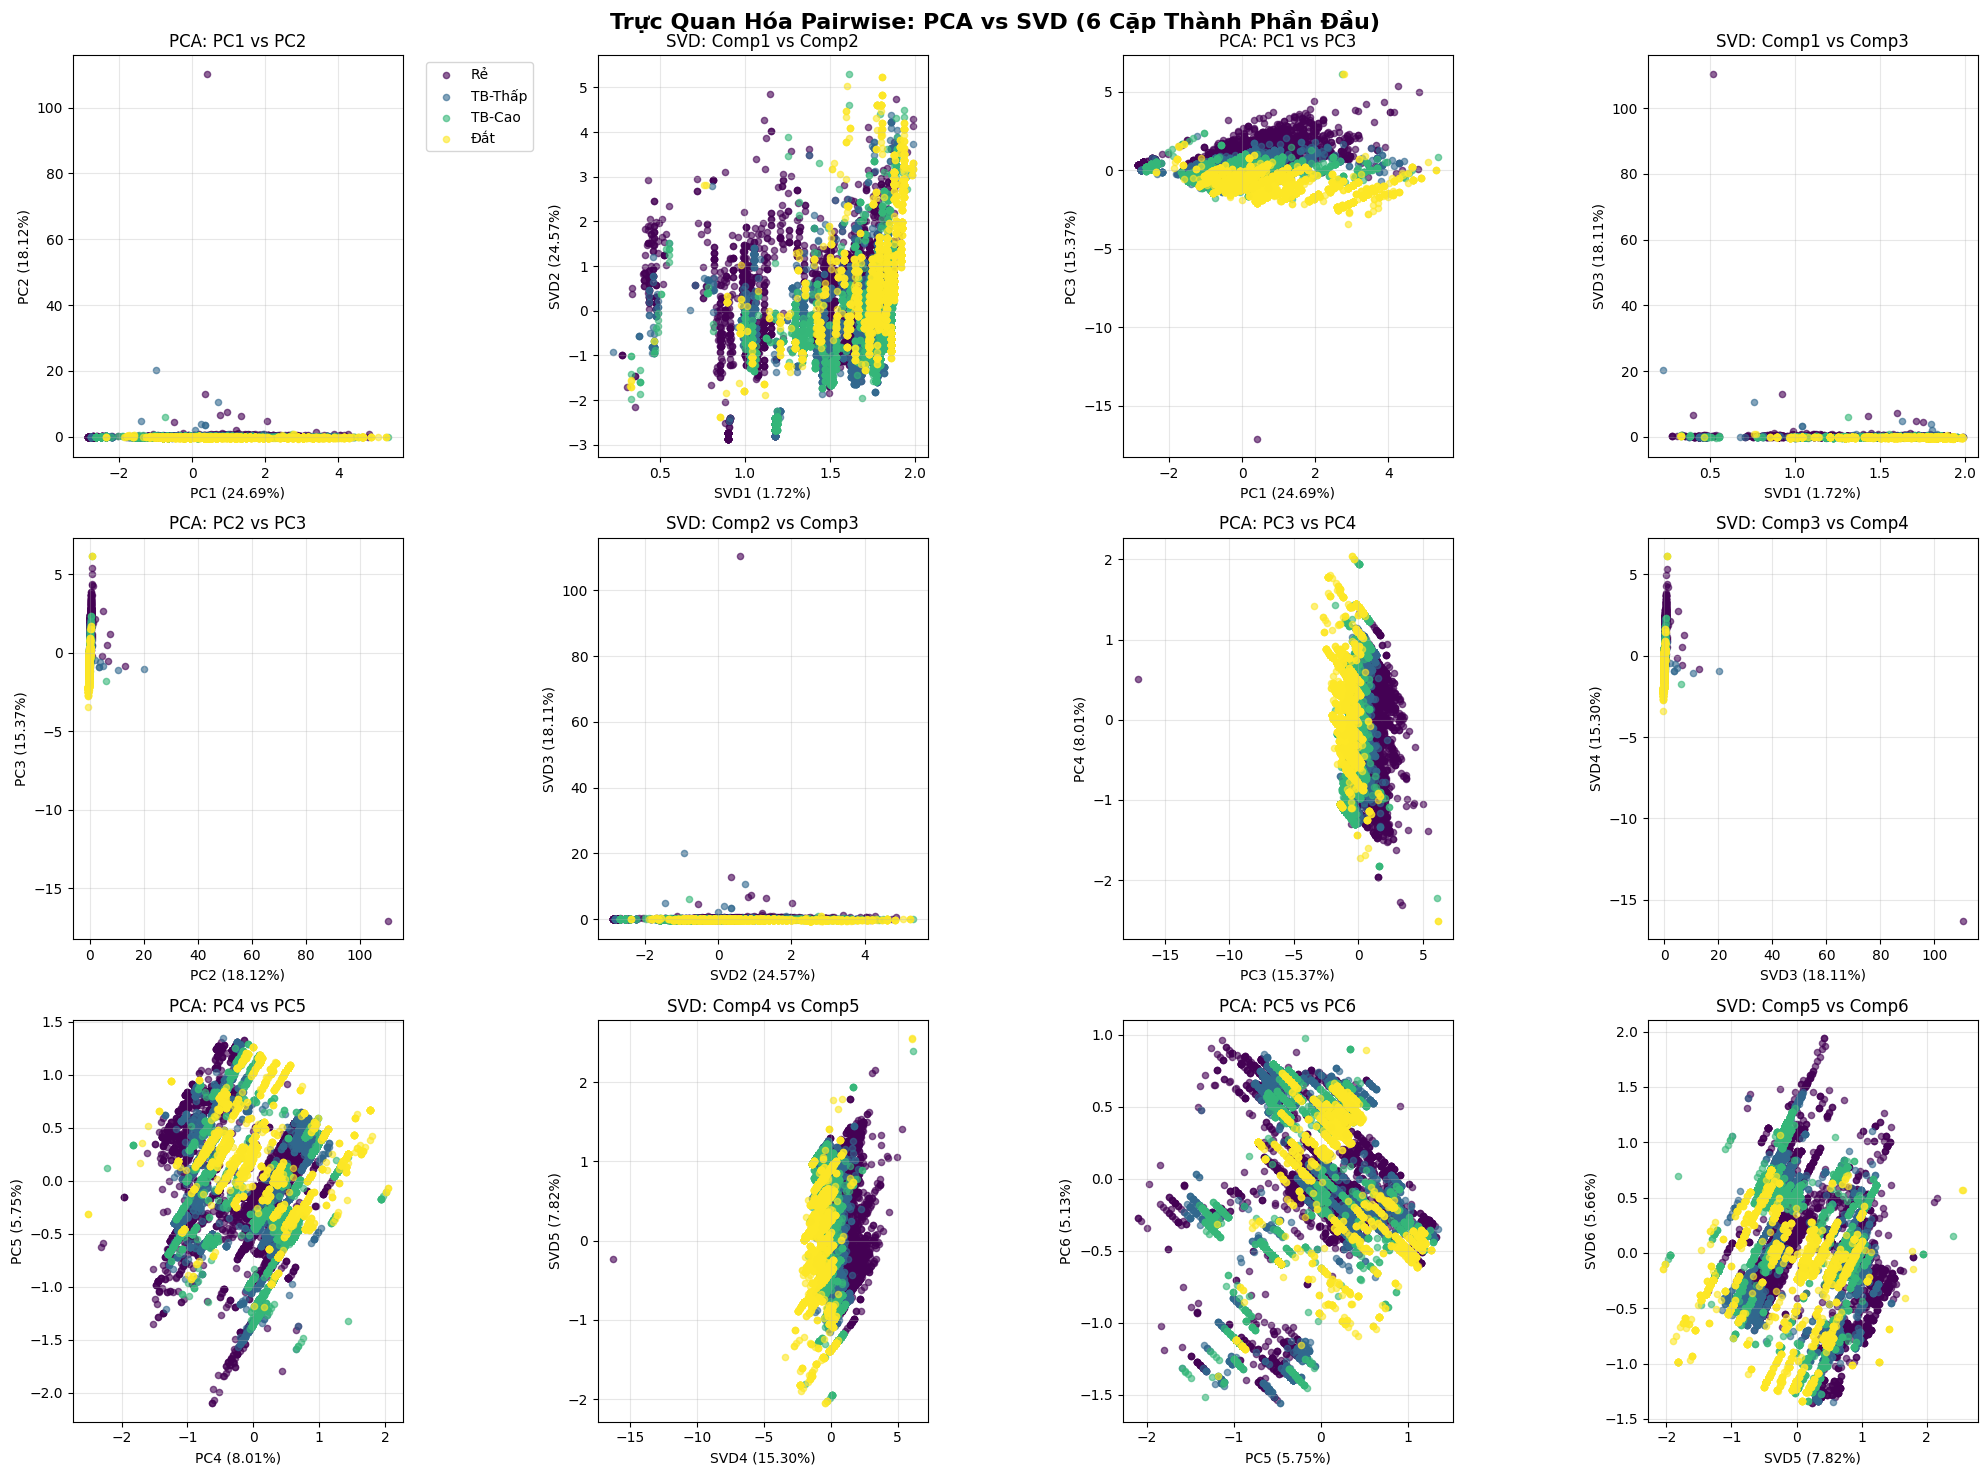

 Đã lưu biểu đồ pairwise analysis!


In [38]:
# Trực quan hóa từng cặp 2 thành phần chính (4-6 cặp đầu tiên)
print("\n TRỰC QUAN HÓA PAIRWISE - TỪNG CẶP 2 THÀNH PHẦN")
print("="*60)

# Tạo colormap dựa trên target (giá xe)
# Chia target thành 4 nhóm màu để dễ phân biệt
target_quartiles = pd.qcut(y_analysis, 4, labels=['Rẻ', 'TB-Thấp', 'TB-Cao', 'Đắt'])
colors = plt.cm.viridis(np.linspace(0, 1, 4))

# Vẽ pairwise plots cho PCA và SVD (6 cặp đầu tiên)
fig, axes = plt.subplots(3, 4, figsize=(20, 15))
fig.suptitle('Trực Quan Hóa Pairwise: PCA vs SVD (6 Cặp Thành Phần Đầu)', 
             fontsize=16, fontweight='bold')

component_pairs = [(0,1), (0,2), (1,2), (2,3), (3,4), (4,5)]

for i, (comp1, comp2) in enumerate(component_pairs):
    # PCA pairwise
    row, col = i // 2, (i % 2) * 2
    ax_pca = axes[row, col]
    
    # Vẽ scatter plot với màu theo giá
    for j, (quartile, color) in enumerate(zip(['Rẻ', 'TB-Thấp', 'TB-Cao', 'Đắt'], colors)):
        mask = target_quartiles == quartile
        ax_pca.scatter(X_pca_6[mask, comp1], X_pca_6[mask, comp2], 
                      c=[color], alpha=0.6, s=20, label=quartile)
    
    ax_pca.set_xlabel(f'PC{comp1+1} ({pca_6.explained_variance_ratio_[comp1]:.2%})')
    ax_pca.set_ylabel(f'PC{comp2+1} ({pca_6.explained_variance_ratio_[comp2]:.2%})')
    ax_pca.set_title(f'PCA: PC{comp1+1} vs PC{comp2+1}')
    ax_pca.grid(True, alpha=0.3)
    if i == 0:
        ax_pca.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # SVD pairwise
    ax_svd = axes[row, col + 1]
    for j, (quartile, color) in enumerate(zip(['Rẻ', 'TB-Thấp', 'TB-Cao', 'Đắt'], colors)):
        mask = target_quartiles == quartile
        ax_svd.scatter(X_svd_6[mask, comp1], X_svd_6[mask, comp2], 
                      c=[color], alpha=0.6, s=20, label=quartile)
    
    ax_svd.set_xlabel(f'SVD{comp1+1} ({svd_6.explained_variance_ratio_[comp1]:.2%})')
    ax_svd.set_ylabel(f'SVD{comp2+1} ({svd_6.explained_variance_ratio_[comp2]:.2%})')
    ax_svd.set_title(f'SVD: Comp{comp1+1} vs Comp{comp2+1}')
    ax_svd.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(MODEL_DIR, 'pairwise_dimensionality_analysis.png'), 
            dpi=300, bbox_inches='tight')
plt.show()

print(" Đã lưu biểu đồ pairwise analysis!")


 SCREE PLOT VÀ SO SÁNH TỔNG THỂ


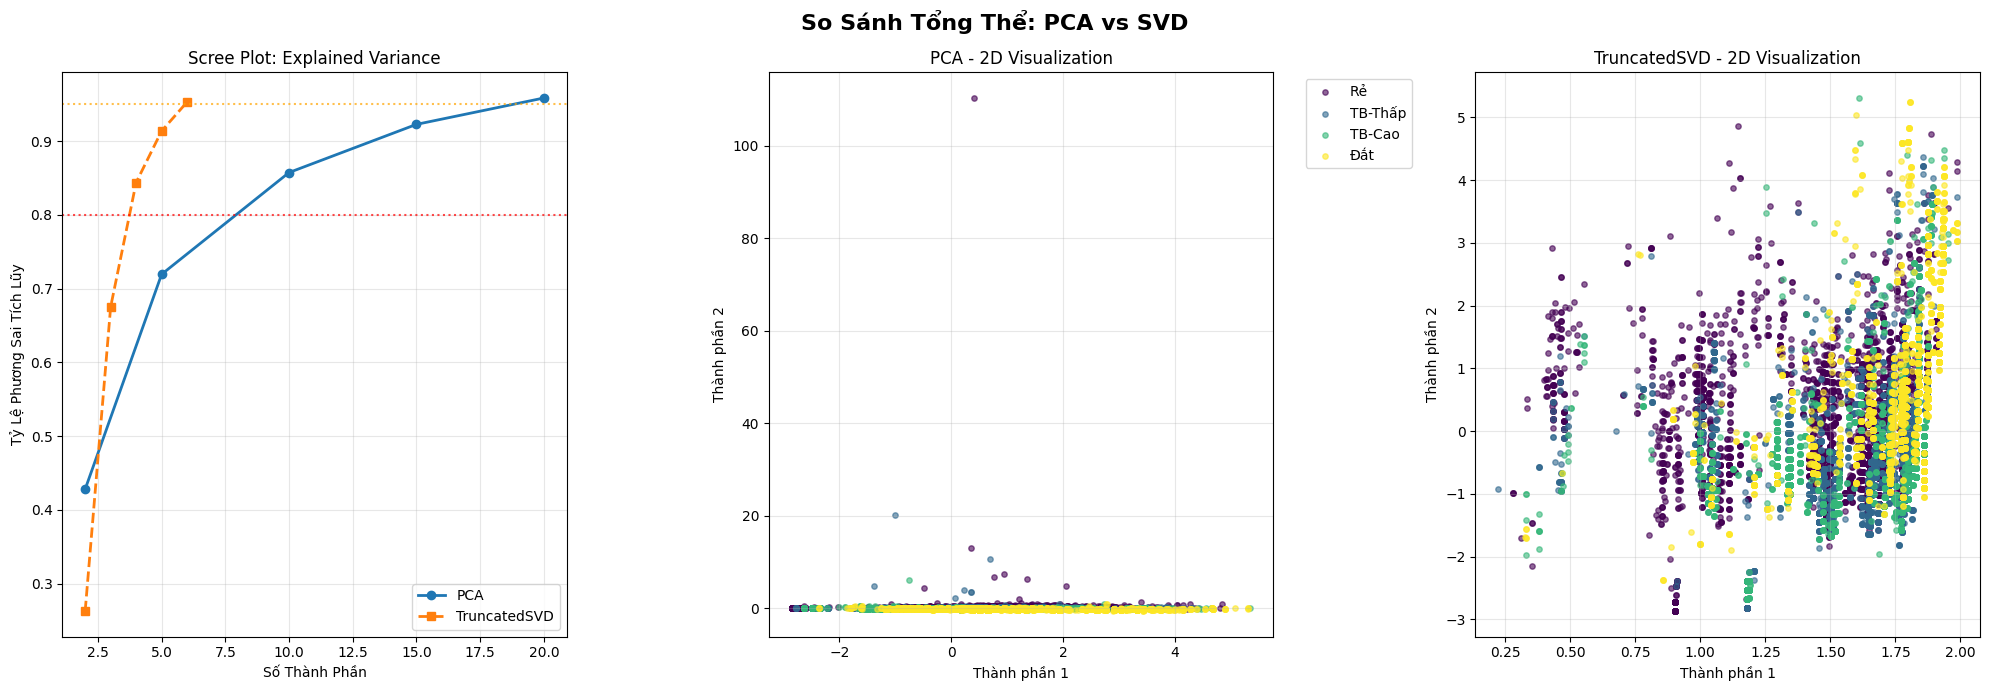


 TÓM TẮT ĐÁNH GIÁ SO SÁNH:
     PCA:          Giải thích 77.1% phương sai, nhanh, dễ hiểu
     TruncatedSVD: Giải thích 73.2% phương sai, tương tự PCA

 Hoàn thành phân tích 02 phương pháp giảm chiều!
 Đã lưu tất cả biểu đồ vào thư mục models/!


In [39]:
print("\n SCREE PLOT VÀ SO SÁNH TỔNG THỂ")
print("="*45)

fig, axes = plt.subplots(1, 3, figsize=(20, 7))
fig.suptitle('So Sánh Tổng Thể: PCA vs SVD', fontsize=16, fontweight='bold')

# 1. Scree Plot - Explained Variance
ax1 = axes[0]
components_range = list(range(1, 21))
pca_variances = [pca_results_analysis[i]['total_variance_explained'] for i in n_components_list if i in pca_results_analysis]
svd_variances = [svd_results[i]['total_variance_explained'] for i in svd_components if i in svd_results]

ax1.plot(n_components_list, pca_variances, 'o-', label='PCA', linewidth=2, markersize=6)
ax1.plot(range(2, len(svd_variances)+2), svd_variances, 's--', label='TruncatedSVD', linewidth=2, markersize=6)
ax1.set_xlabel('Số Thành Phần')
ax1.set_ylabel('Tỷ Lệ Phương Sai Tích Lũy')
ax1.set_title('Scree Plot: Explained Variance')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.axhline(y=0.8, color='red', linestyle=':', alpha=0.7, label='80% threshold')
ax1.axhline(y=0.95, color='orange', linestyle=':', alpha=0.7, label='95% threshold')

# 2. So sánh 2D visualization của 2 phương pháp
methods = ['PCA', 'TruncatedSVD']
method_data = [
    dimensionality_results['PCA']['components_2d'],
    dimensionality_results['TruncatedSVD']['components_2d']
]

# Tách y_analysis và target_quartiles ra (nếu chưa có)
y_analysis = df[target]
target_quartiles = pd.qcut(y_analysis, 4, labels=['Rẻ', 'TB-Thấp', 'TB-Cao', 'Đắt'])
colors = plt.cm.viridis(np.linspace(0, 1, 4))


for i, (method, data) in enumerate(zip(methods, method_data)):
    ax = axes[i + 1] # Bắt đầu từ axes[1] và axes[2]
    
    data_plot = data
    target_plot = target_quartiles
    
    # Vẽ scatter với màu theo quartile
    for j, (quartile, color) in enumerate(zip(['Rẻ', 'TB-Thấp', 'TB-Cao', 'Đắt'], colors)):
        mask = target_plot == quartile
        if np.any(mask):
            ax.scatter(data_plot[mask, 0], data_plot[mask, 1], 
                       c=[color], alpha=0.6, s=15, label=quartile if i == 0 else "")
    
    ax.set_title(f'{method} - 2D Visualization')
    ax.set_xlabel('Thành phần 1')
    ax.set_ylabel('Thành phần 2')
    ax.grid(True, alpha=0.3)
    
    if i == 0:  # Chỉ hiển thị legend cho plot đầu tiên (PCA)
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.savefig(os.path.join(MODEL_DIR, 'comprehensive_dimensionality_comparison.png'), 
            dpi=300, bbox_inches='tight')
plt.show()

# Tóm tắt đánh giá so sánh
print(f"\n TÓM TẮT ĐÁNH GIÁ SO SÁNH:")
print(f"     PCA:          Giải thích {pca_6.explained_variance_ratio_.sum():.1%} phương sai, nhanh, dễ hiểu")
print(f"     TruncatedSVD: Giải thích {svd_6.explained_variance_ratio_.sum():.1%} phương sai, tương tự PCA")

print(f"\n Hoàn thành phân tích 02 phương pháp giảm chiều!")
print(" Đã lưu tất cả biểu đồ vào thư mục models/!")


## 1.3. Phân Cụm Dữ Liệu 
### KMeans, GMM và DBSCAN

Thực hiện phân cụm dữ liệu sau khi bỏ qua trường đầu ra để khám phá cấu trúc ẩn trong dữ liệu với ít nhất 2 trong 3 phương pháp: KMeans, GMM, DBSCAN.

In [40]:
print(" PHÂN CỤM DỮ LIỆU")
print("="*60)

# Chuẩn bị dữ liệu cho phân cụm (không bao gồm target)
X_cluster = df[all_features].copy()
print(f" Dữ liệu phân cụm: {X_cluster.shape}")

# Tiền xử lý dữ liệu cho phân cụm
X_cluster_processed = preprocessor.fit_transform(X_cluster)

# Chuyển đổi sparse matrix thành dense nếu cần
if hasattr(X_cluster_processed, 'toarray'):
    X_cluster_dense = X_cluster_processed.toarray()
else:
    X_cluster_dense = X_cluster_processed

print(f" Dữ liệu sau tiền xử lý: {X_cluster_dense.shape}")

# Thực hiện PCA để giảm chiều cho việc trực quan hóa
pca_viz = PCA(n_components=2, random_state=42)
X_pca_2d = pca_viz.fit_transform(X_cluster_dense)

print(f" Dữ liệu PCA 2D: {X_pca_2d.shape}")
print(f" Tỷ lệ phương sai giải thích bởi 2 PC: {pca_viz.explained_variance_ratio_.sum():.3f}")

# Khởi tạo dictionary lưu kết quả phân cụm
clustering_results = {}
cluster_labels = {}

 PHÂN CỤM DỮ LIỆU
 Dữ liệu phân cụm: (13453, 8)
 Dữ liệu sau tiền xử lý: (13453, 82)
 Dữ liệu PCA 2D: (13453, 2)
 Tỷ lệ phương sai giải thích bởi 2 PC: 0.428


In [41]:
# 1. KMeans Clustering
print("\n 1. KMEANS CLUSTERING")
print("-" * 40)

# Tìm số cụm tối ưu bằng Elbow method và Silhouette score
k_range = range(2, 11)
kmeans_scores = []
silhouette_scores = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_cluster_dense)
    
    # Tính silhouette score
    sil_score = silhouette_score(X_cluster_dense, labels)
    silhouette_scores.append(sil_score)
    
    # Lưu inertia cho Elbow method
    kmeans_scores.append(kmeans.inertia_)
    
    print(f"   K={k}: Silhouette={sil_score:.3f}, Inertia={kmeans.inertia_:.0f}")

# Chọn số cụm tối ưu (silhouette score cao nhất)
optimal_k = k_range[np.argmax(silhouette_scores)]
best_silhouette = max(silhouette_scores)

print(f"\n Số cụm tối ưu cho KMeans: K={optimal_k} (Silhouette={best_silhouette:.3f})")

# Huấn luyện KMeans với số cụm tối ưu
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
kmeans_labels = kmeans_final.fit_predict(X_cluster_dense)

cluster_labels['KMeans'] = kmeans_labels
clustering_results['KMeans'] = {
    'n_clusters': optimal_k,
    'silhouette_score': silhouette_score(X_cluster_dense, kmeans_labels),
    'labels': kmeans_labels
}


 1. KMEANS CLUSTERING
----------------------------------------
   K=2: Silhouette=0.215, Inertia=63320
   K=2: Silhouette=0.215, Inertia=63320
   K=3: Silhouette=0.212, Inertia=50852
   K=3: Silhouette=0.212, Inertia=50852
   K=4: Silhouette=0.188, Inertia=44794
   K=4: Silhouette=0.188, Inertia=44794
   K=5: Silhouette=0.174, Inertia=39442
   K=5: Silhouette=0.174, Inertia=39442
   K=6: Silhouette=0.183, Inertia=36825
   K=6: Silhouette=0.183, Inertia=36825
   K=7: Silhouette=0.205, Inertia=34295
   K=7: Silhouette=0.205, Inertia=34295
   K=8: Silhouette=0.185, Inertia=32313
   K=8: Silhouette=0.185, Inertia=32313
   K=9: Silhouette=0.193, Inertia=30800
   K=9: Silhouette=0.193, Inertia=30800
   K=10: Silhouette=0.209, Inertia=29264

 Số cụm tối ưu cho KMeans: K=2 (Silhouette=0.215)
   K=10: Silhouette=0.209, Inertia=29264

 Số cụm tối ưu cho KMeans: K=2 (Silhouette=0.215)


In [42]:
# 2. DBSCAN Clustering
print("\n 3. DBSCAN CLUSTERING")
print("-" * 40)

# Thử nghiệm với các giá trị eps khác nhau
eps_values = [0.5, 1.0, 1.5, 2.0, 2.5]
dbscan_results = []

for eps in eps_values:
    dbscan = DBSCAN(eps=eps, min_samples=5)
    dbscan_labels = dbscan.fit_predict(X_cluster_dense)
    
    # Đếm số cụm (không tính noise points = -1)
    n_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
    n_noise = list(dbscan_labels).count(-1)
    
    # Tính silhouette score nếu có ít nhất 2 cụm
    if n_clusters >= 2:
        sil_score = silhouette_score(X_cluster_dense, dbscan_labels)
    else:
        sil_score = -1
    
    dbscan_results.append({
        'eps': eps,
        'n_clusters': n_clusters,
        'n_noise': n_noise,
        'silhouette_score': sil_score,
        'labels': dbscan_labels
    })
    
    print(f"   eps={eps}: Cụm={n_clusters}, Noise={n_noise}, Silhouette={sil_score:.3f}")

# Chọn DBSCAN tối ưu (silhouette score cao nhất)
valid_dbscan = [r for r in dbscan_results if r['silhouette_score'] > 0]
if valid_dbscan:
    best_dbscan = max(valid_dbscan, key=lambda x: x['silhouette_score'])
    print(f"\n DBSCAN tối ưu: eps={best_dbscan['eps']} (Silhouette={best_dbscan['silhouette_score']:.3f})")
    
    cluster_labels['DBSCAN'] = best_dbscan['labels']
    clustering_results['DBSCAN'] = best_dbscan
else:
    print("\n DBSCAN không tìm được cấu hình phù hợp")
    cluster_labels['DBSCAN'] = np.zeros(len(X_cluster_dense))
    clustering_results['DBSCAN'] = {'n_clusters': 1, 'silhouette_score': -1}


 3. DBSCAN CLUSTERING
----------------------------------------
   eps=0.5: Cụm=261, Noise=760, Silhouette=0.491
   eps=0.5: Cụm=261, Noise=760, Silhouette=0.491
   eps=1.0: Cụm=231, Noise=459, Silhouette=0.478
   eps=1.0: Cụm=231, Noise=459, Silhouette=0.478
   eps=1.5: Cụm=10, Noise=79, Silhouette=-0.014
   eps=1.5: Cụm=10, Noise=79, Silhouette=-0.014
   eps=2.0: Cụm=4, Noise=30, Silhouette=0.098
   eps=2.0: Cụm=4, Noise=30, Silhouette=0.098
   eps=2.5: Cụm=1, Noise=16, Silhouette=-1.000

 DBSCAN tối ưu: eps=0.5 (Silhouette=0.491)
   eps=2.5: Cụm=1, Noise=16, Silhouette=-1.000

 DBSCAN tối ưu: eps=0.5 (Silhouette=0.491)


In [43]:
# Phân tích mối quan hệ giữa các cụm và giá trị target
print("\n PHÂN TÍCH MỐI QUAN HỆ CỤM - GIÁ TRỊ TARGET")
print("="*60)

target_values = df[target].values

for method_name, labels in cluster_labels.items():
    if clustering_results[method_name]['silhouette_score'] <= 0:
        continue
        
    print(f"\n {method_name}:")
    print(f"    Số cụm: {clustering_results[method_name]['n_clusters']}")
    print(f"    Silhouette Score: {clustering_results[method_name]['silhouette_score']:.3f}")
    
    # Thống kê target theo từng cụm
    unique_labels = np.unique(labels)
    cluster_stats = []
    
    for cluster_id in unique_labels:
        if cluster_id == -1:  # Bỏ qua noise points trong DBSCAN
            continue
            
        cluster_mask = labels == cluster_id
        cluster_targets = target_values[cluster_mask]
        
        stats = {
            'cluster': cluster_id,
            'count': len(cluster_targets),
            'mean_price': np.mean(cluster_targets),
            'std_price': np.std(cluster_targets),
            'min_price': np.min(cluster_targets),
            'max_price': np.max(cluster_targets)
        }
        cluster_stats.append(stats)
        
        print(f"    Cụm {cluster_id}: {len(cluster_targets):4d} xe, "
              f"Giá TB: {np.mean(cluster_targets):6.1f}T, "
              f"Std: {np.std(cluster_targets):5.1f}T")
    
    # Lưu thống kê để sử dụng sau
    clustering_results[method_name]['cluster_stats'] = cluster_stats

print(f"\n Hoàn thành phân tích phân cụm!")


 PHÂN TÍCH MỐI QUAN HỆ CỤM - GIÁ TRỊ TARGET

 KMeans:
    Số cụm: 2
    Silhouette Score: 0.215
    Cụm 0: 3848 xe, Giá TB: 1870.2T, Std: 2712.1T
    Cụm 1: 9605 xe, Giá TB: 1165.0T, Std: 1309.9T

 DBSCAN:
    Số cụm: 261
    Silhouette Score: 0.491
    Cụm 0:  444 xe, Giá TB:  963.8T, Std: 463.0T
    Cụm 1:  296 xe, Giá TB:  742.7T, Std: 193.1T
    Cụm 2:  528 xe, Giá TB: 1324.5T, Std: 418.1T
    Cụm 3:  165 xe, Giá TB:  526.9T, Std:  64.7T
    Cụm 4:   51 xe, Giá TB: 1235.7T, Std: 407.4T
    Cụm 5:   87 xe, Giá TB:  808.4T, Std: 238.3T
    Cụm 6:   90 xe, Giá TB:  642.1T, Std:  61.4T
    Cụm 7:   82 xe, Giá TB: 1296.9T, Std: 579.8T
    Cụm 8:   70 xe, Giá TB: 3586.6T, Std: 852.6T
    Cụm 9:    5 xe, Giá TB: 13500.0T, Std: 547.7T
    Cụm 10:  201 xe, Giá TB: 3844.8T, Std: 2850.8T
    Cụm 11:   13 xe, Giá TB:  233.0T, Std:  39.8T
    Cụm 12:  276 xe, Giá TB: 1512.0T, Std: 842.2T
    Cụm 13:   36 xe, Giá TB:  745.0T, Std: 114.1T
    Cụm 14:   39 xe, Giá TB:  538.7T, Std: 217.8T
    Cụm


 TRỰC QUAN HÓA KẾT QUẢ PHÂN CỤM


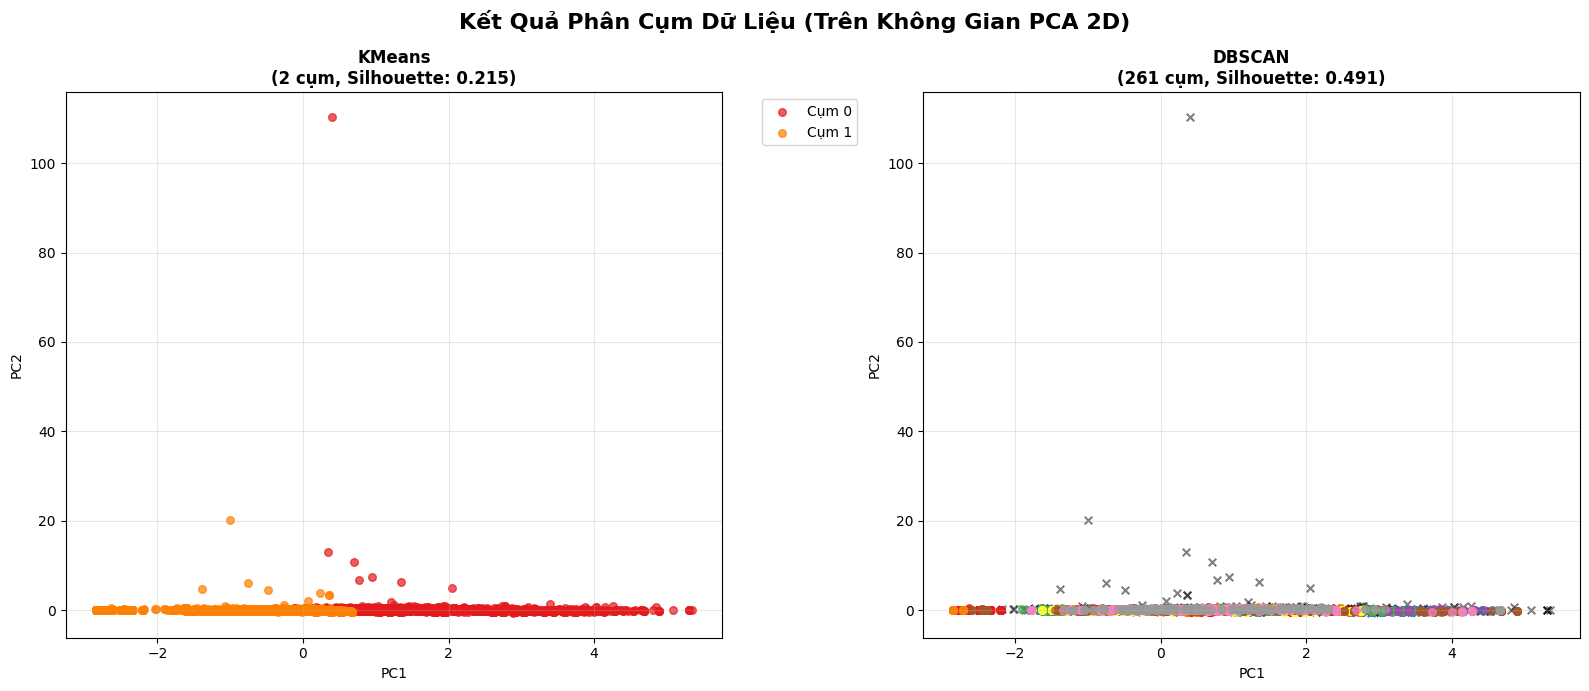

 Đã lưu biểu đồ phân tích phân cụm!


In [44]:
print("\n TRỰC QUAN HÓA KẾT QUẢ PHÂN CỤM")
print("="*50)

# TỐI ƯU: Đổi layout từ 2x2 (4 ô) sang 1x2 (2 ô) vì đã bỏ GMM
n_methods = len([m for m in cluster_labels.keys() if clustering_results[m]['silhouette_score'] > 0])
# Đảm bảo n_methods ít nhất là 2 để không lỗi, hoặc 1 nếu DBSCAN thất bại
plot_cols = max(1, n_methods) 
fig, axes = plt.subplots(1, plot_cols, figsize=(8 * plot_cols, 7))
fig.suptitle('Kết Quả Phân Cụm Dữ Liệu (Trên Không Gian PCA 2D)', fontsize=16, fontweight='bold')

# Nếu chỉ có 1 biểu đồ, axes không phải là mảng, cần bọc lại
if plot_cols == 1:
    axes = [axes]

plot_idx = 0
colors_cluster = plt.cm.Set1

for method_name, labels in cluster_labels.items():
    if clustering_results[method_name]['silhouette_score'] <= 0:
        continue
    
    if plot_idx < plot_cols:
        ax = axes[plot_idx]
        
        # Vẽ scatter plot với màu theo cụm
        unique_labels = np.unique(labels)
        for i, label in enumerate(unique_labels):
            if label == -1:  # Noise points cho DBSCAN
                color = 'black'
                marker = 'x'
                alpha = 0.5
            else:
                color = colors_cluster(i / len(unique_labels))
                marker = 'o'
                alpha = 0.7
            
            mask = labels == label
            ax.scatter(X_pca_2d[mask, 0], X_pca_2d[mask, 1], 
                       c=[color], marker=marker, alpha=alpha, s=30,
                       label=f'Cụm {label}' if label != -1 else 'Noise')
        
        ax.set_title(f'{method_name}\n({clustering_results[method_name]["n_clusters"]} cụm, '
                     f'Silhouette: {clustering_results[method_name]["silhouette_score"]:.3f})',
                     fontweight='bold')
        ax.set_xlabel('PC1')
        ax.set_ylabel('PC2')
        ax.grid(True, alpha=0.3)
        
        # Chỉ hiện legend cho plot đầu tiên
        if plot_idx == 0:
            ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        
        plot_idx += 1

# TỐI ƯU: Đã xóa vòng lặp "Xóa subplot trống" vì layout đã chuẩn 1x2

plt.tight_layout()
plt.savefig(os.path.join(MODEL_DIR, 'clustering_analysis.png'), dpi=300, bbox_inches='tight')
plt.show()

print(" Đã lưu biểu đồ phân tích phân cụm!")

# 1.4a. Phân Tích Hồi Quy

In [45]:
# Reset lưu trữ để có thể chạy lại cell này
all_results = {}
best_models_by_split = {}
residual_data = {}

print("\n BẮT ĐẦU HUẤN LUYỆN VÒNG LẶP")
print("="*60)

# =========================
# Huấn luyện trên từng split
# =========================
for i, (train_ratio, test_ratio) in enumerate(split_ratios):
    split_name = split_names[i]
    print(f"\n Đang xử lý Split {split_name} ({int(train_ratio*100)}-{int(test_ratio*100)})...")

    # Chia dữ liệu
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_ratio, random_state=42
    )

    split_results = {}

    for model_name, model_base in MODEL_LIST:
        # Tạo pipeline mới cho mỗi lần chạy
        pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('model', clone(model_base))
        ])

        # GridSearchCV nếu có tham số
        if param_grids.get(model_name):
            grid = GridSearchCV(pipeline, param_grids[model_name], cv=3, scoring='r2', n_jobs=-1)
            grid.fit(X_train, y_train)
            final_model = grid.best_estimator_
        else:
            pipeline.fit(X_train, y_train)
            final_model = pipeline

        # Dự đoán và đánh giá
        y_pred = final_model.predict(X_test)
        r2 = r2_score(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        mae = mean_absolute_error(y_test, y_pred)

        # Cross-validation chỉ cho split đầu tiên
        cv_mean = cv_std = overfitting = 0
        if i == 0:
            try:
                cv_scores = cross_val_score(final_model, X_train, y_train, cv=3, scoring='r2')
                cv_mean, cv_std = cv_scores.mean(), cv_scores.std()
                overfitting = cv_mean - r2
            except Exception as e:
                print(f" Lỗi CV mô hình {model_name}: {e}")

        # Lưu kết quả
        split_results[model_name] = {
            'R2': r2, 'RMSE': rmse, 'MAE': mae,
            'CV_R2_mean': cv_mean, 'CV_R2_std': cv_std,
            'Overfitting': overfitting
        }

        # Lưu residuals
        residual_data[f"{model_name}_{split_name}"] = {
            'y_true': y_test, 'y_pred': y_pred,
            'residuals': y_test - y_pred, 'X_test': X_test
        }

    # Lưu kết quả split và tìm model tốt nhất
    all_results[split_name] = split_results
    best_model = max(split_results, key=lambda k: split_results[k]['R2'])
    best_models_by_split[split_name] = best_model

print("\n Hoàn thành huấn luyện vòng lặp!")
print("="*60)



 BẮT ĐẦU HUẤN LUYỆN VÒNG LẶP

 Đang xử lý Split 4:1 (80-20)...


c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.518e+06, tolerance: 2.369e+06
  model = cd_fast.sparse_enet_coordinate_descent(
c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.009e+07, tolerance: 2.413e+06
  model = cd_fast.sparse_enet_coordinate_descent(
c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, ch


 Đang xử lý Split 7:3 (70-30)...


c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.617e+06, tolerance: 3.269e+06
  model = cd_fast.sparse_enet_coordinate_descent(



 Đang xử lý Split 6:4 (60-40)...


c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.474e+06, tolerance: 2.730e+06
  model = cd_fast.sparse_enet_coordinate_descent(



 Hoàn thành huấn luyện vòng lặp!


In [46]:
print("\n TỔNG KẾT KẾT QUẢ HUẤN LUYỆN")
print("="*60)

if not all_results:
    print(" Lỗi: 'all_results' trống. Bạn cần chạy Cell trước.")
else:
    print(f" Số splits đã huấn luyện: {len(all_results)}")
    print(f" Danh sách splits: {list(all_results.keys())}")

    for split_name, results in all_results.items():
        print(f"\n SPLIT {split_name}:")
        print(f"   Số mô hình: {len(results)}")
        
        # Sắp xếp theo R² giảm dần
        sorted_models = sorted(results.items(), key=lambda x: x[1]['R2'], reverse=True)
        
        print("   " + "-"*50)
        print("   {:<15} | {:>8} | {:>8} | {:>8}".format("Mô hình", "R²", "RMSE", "CV R²"))
        print("   " + "-"*50)
        for model_name, metrics in sorted_models:
            print("   {:<15} | {:8.3f} | {:8.0f} | {:8.3f}".format(
                model_name, 
                metrics['R2'],
                metrics['RMSE'],
                metrics['CV_R2_mean'] # Sẽ là 0 cho các split không phải đầu tiên
            ))
        print("   " + "-"*50)

    print(f"\n TÓM TẮT MÔ HÌNH TỐT NHẤT:")
    print("   " + "-"*40)
    print("   {:<10} | {:<15} | {:>8}".format("Split", "Mô hình", "R²"))
    print("   " + "-"*40)
    for split_name, best_model in best_models_by_split.items():
        r2_value = all_results[split_name][best_model]['R2']
        print("   {:<10} | {:<15} | {:8.3f}".format(split_name, best_model, r2_value))
    print("   " + "-"*40)

# =========================
# HUẤN LUYỆN & LƯU MÔ HÌNH FINAL
# =========================
print("\n Đang huấn luyện & lưu mô hình final (từ split 80-20)...")

# Reset dict chứa mô hình đã huấn luyện
trained_models = {}

# Sử dụng split 80-20 cố định để huấn luyện mô hình cuối cùng
X_train_final, _, y_train_final, _ = train_test_split(
    X, y, test_size=0.2, random_state=42
)

for model_name, model_base in MODEL_LIST:
    print(f"  Đang huấn luyện final: {model_name}...")
    pipeline = Pipeline([('preprocessor', preprocessor), ('model', clone(model_base))])
    
    if param_grids.get(model_name):
        grid = GridSearchCV(pipeline, param_grids[model_name], cv=3, scoring='r2', n_jobs=-1)
        grid.fit(X_train_final, y_train_final)
        final_model_to_save = grid.best_estimator_
    else:
        pipeline.fit(X_train_final, y_train_final)
        final_model_to_save = pipeline

    # Lưu vào dict và dump ra file
    trained_models[model_name] = final_model_to_save
    joblib.dump(final_model_to_save, os.path.join(MODEL_DIR, f"{model_name}_model.pkl"))

print(f"\n Đã lưu {len(trained_models)} mô hình final vào thư mục {MODEL_DIR}!")
print("="*60)



 TỔNG KẾT KẾT QUẢ HUẤN LUYỆN
 Số splits đã huấn luyện: 3
 Danh sách splits: ['4:1', '7:3', '6:4']

 SPLIT 4:1:
   Số mô hình: 4
   --------------------------------------------------
   Mô hình         |       R² |     RMSE |    CV R²
   --------------------------------------------------
   KNN             |    0.968 |      331 |    0.953
   RandomForest    |    0.950 |      409 |    0.939
   LinearRegression |    0.641 |     1102 |    0.662
   Lasso           |    0.640 |     1102 |    0.662
   --------------------------------------------------

 SPLIT 7:3:
   Số mô hình: 4
   --------------------------------------------------
   Mô hình         |       R² |     RMSE |    CV R²
   --------------------------------------------------
   KNN             |    0.974 |      294 |    0.000
   RandomForest    |    0.958 |      375 |    0.000
   LinearRegression |    0.666 |     1056 |    0.000
   Lasso           |    0.665 |     1057 |    0.000
   ----------------------------------------------

In [47]:
# - So sánh dữ liệu gốc vs dữ liệu giảm chiều
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

print(" PHÂN TÍCH GIẢM CHIỀU PCA")
print("="*60)

# Lưu trữ kết quả so sánh PCA
pca_results = {}
n_components_list = [5, 10, 15, 'original']

# Sử dụng tỷ lệ chia 4:1 cho phân tích PCA - tạo lại split
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Áp dụng tiền xử lý để chuyển đổi đặc trưng phân loại thành số
X_train_preprocessed = preprocessor.fit_transform(X_train_pca)
X_test_preprocessed = preprocessor.transform(X_test_pca)

print(f" Chiều đặc trưng gốc: {X_train_preprocessed.shape[1]} đặc trưng (sau tiền xử lý)")

# Chuyển đổi ma trận thưa thành ma trận dày nếu cần và đảm bảo đã được chuẩn hóa đúng
# Bộ tiền xử lý đã áp dụng StandardScaler cho đặc trưng số
if hasattr(X_train_preprocessed, 'toarray'):
    X_train_scaled = X_train_preprocessed.toarray()
    X_test_scaled = X_test_preprocessed.toarray()
else:
    X_train_scaled = X_train_preprocessed
    X_test_scaled = X_test_preprocessed

print(f" Dữ liệu đã chuyển sang định dạng dày: {X_train_scaled.shape}")

# Kiểm tra các số lượng thành phần chính khác nhau
for n_comp in n_components_list:
    print(f"\n Kiểm tra với {n_comp} thành phần...")
    
    if n_comp == 'original':
        # Sử dụng đặc trưng gốc (không PCA)
        X_train_final = X_train_scaled
        X_test_final = X_test_scaled
        feature_count = X_train_preprocessed.shape[1]
    else:
        # Áp dụng PCA
        pca = PCA(n_components=n_comp, random_state=42)
        X_train_final = pca.fit_transform(X_train_scaled)
        X_test_final = pca.transform(X_test_scaled)
        feature_count = n_comp
        
        # In tỷ lệ phương sai được giải thích
        explained_variance_ratio = pca.explained_variance_ratio_
        cumulative_variance = np.cumsum(explained_variance_ratio)
        print(f"    Tỷ lệ phương sai giải thích: {explained_variance_ratio.sum():.3f}")
        print(f"    Phương sai tích lũy: {cumulative_variance[-1]:.3f}")
    
    # Kiểm tra mô hình với bộ đặc trưng hiện tại
    pca_results[f'{feature_count}_components'] = {
        'feature_count': feature_count,
        'models': {}
    }
    
    for model_name, model in models.items():
        # Huấn luyện đơn giản không tối ưu tham số mở rộng cho so sánh PCA
        from sklearn.base import clone
        model_copy = clone(model)
        model_copy.fit(X_train_final, y_train_pca)
        y_pred = model_copy.predict(X_test_final)
        
        # Tính toán các chỉ số
        mse = mean_squared_error(y_test_pca, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test_pca, y_pred)
        r2_metric = r2_score(y_test_pca, y_pred)
        
        pca_results[f'{feature_count}_components']['models'][model_name] = {
            'mse': mse,
            'rmse': rmse,
            'mae': mae,
            'r2': r2_metric
        }
        
        print(f"    {model_name}: R² = {r2_metric:.3f}, RMSE = {rmse:.3f}")

print("\n Phân tích PCA hoàn thành!")

 PHÂN TÍCH GIẢM CHIỀU PCA
 Chiều đặc trưng gốc: 81 đặc trưng (sau tiền xử lý)
 Dữ liệu đã chuyển sang định dạng dày: (10762, 81)

 Kiểm tra với 5 thành phần...
    Tỷ lệ phương sai giải thích: 0.719
    Phương sai tích lũy: 0.719
    LinearRegression: R² = 0.473, RMSE = 1334.523
    KNN: R² = 0.908, RMSE = 556.848
    Lasso: R² = 0.473, RMSE = 1334.472
    RandomForest: R² = 0.935, RMSE = 467.175

 Kiểm tra với 10 thành phần...
    Tỷ lệ phương sai giải thích: 0.857
    Phương sai tích lũy: 0.857
    LinearRegression: R² = 0.485, RMSE = 1319.150
    KNN: R² = 0.911, RMSE = 549.116
    Lasso: R² = 0.485, RMSE = 1319.037
    RandomForest: R² = 0.935, RMSE = 467.175

 Kiểm tra với 10 thành phần...
    Tỷ lệ phương sai giải thích: 0.857
    Phương sai tích lũy: 0.857
    LinearRegression: R² = 0.485, RMSE = 1319.150
    KNN: R² = 0.911, RMSE = 549.116
    Lasso: R² = 0.485, RMSE = 1319.037
    RandomForest: R² = 0.939, RMSE = 453.322

 Kiểm tra với 15 thành phần...
    Tỷ lệ phương sai giả


 SO SÁNH HIỆU SUẤT PCA


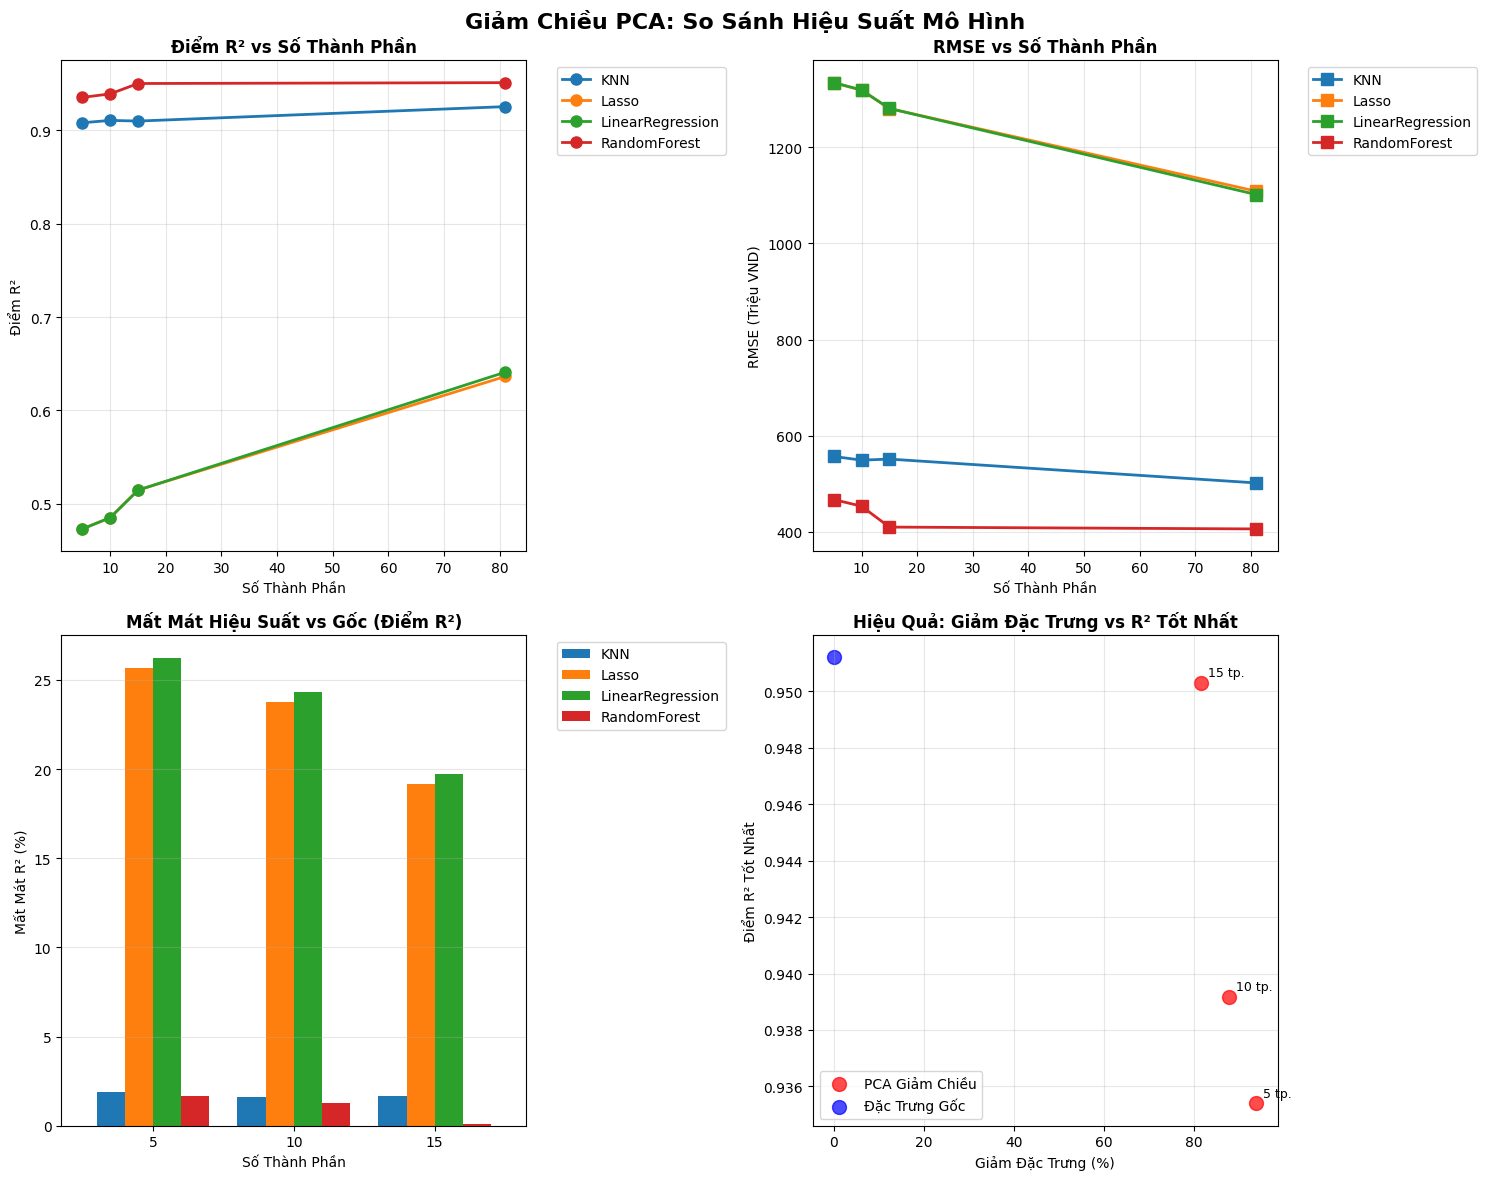


 TÓM TẮT PHÂN TÍCH PCA:
--------------------------------------------------
    🔹  5 thành phần: R² = 0.935 (mất:   1.7%, giảm: 93.8%)
    🔹 10 thành phần: R² = 0.939 (mất:   1.3%, giảm: 87.7%)
    🔹 15 thành phần: R² = 0.950 (mất:   0.1%, giảm: 81.5%)

 Cân bằng tối ưu: Sử dụng 15 thành phần để giảm 81.5% đặc trưng, với mất mát hiệu suất gần như bằng 0 (0.1%)!


In [48]:
# Trực quan hóa So sánh Kết quả PCA
print("\n SO SÁNH HIỆU SUẤT PCA")
print("="*60)

# Tạo dataframe so sánh để trực quan hóa
pca_comparison_data = []
for comp_key, comp_data in pca_results.items():
    feature_count = comp_data['feature_count']
    for model_name, metrics in comp_data['models'].items():
        pca_comparison_data.append({
            'Components': feature_count,
            'Model': model_name,
            'R²': metrics['r2'],
            'RMSE': metrics['rmse'],
            'MAE': metrics['mae']
        })

pca_df = pd.DataFrame(pca_comparison_data)

# Vẽ so sánh PCA
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Giảm Chiều PCA: So Sánh Hiệu Suất Mô Hình', 
             fontsize=16, fontweight='bold')

# So sánh R²
pivot_r2 = pca_df.pivot(index='Components', columns='Model', values='R²')
pivot_r2.plot(kind='line', ax=axes[0,0], marker='o', linewidth=2, markersize=8)
axes[0,0].set_title('Điểm R² vs Số Thành Phần', fontweight='bold')
axes[0,0].set_xlabel('Số Thành Phần')
axes[0,0].set_ylabel('Điểm R²')
axes[0,0].grid(True, alpha=0.3)
axes[0,0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# So sánh RMSE
pivot_rmse = pca_df.pivot(index='Components', columns='Model', values='RMSE')
pivot_rmse.plot(kind='line', ax=axes[0,1], marker='s', linewidth=2, markersize=8)
axes[0,1].set_title('RMSE vs Số Thành Phần', fontweight='bold')
axes[0,1].set_xlabel('Số Thành Phần')
axes[0,1].set_ylabel('RMSE (Triệu VND)')
axes[0,1].grid(True, alpha=0.3)
axes[0,1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Phân tích suy giảm hiệu suất
original_scores = pca_df[pca_df['Components'] == pca_df['Components'].max()]
performance_loss = []

for comp in [5, 10, 15]:
    comp_scores = pca_df[pca_df['Components'] == comp]
    for model in comp_scores['Model'].unique():
        orig_r2 = original_scores[original_scores['Model'] == model]['R²'].iloc[0]
        comp_r2 = comp_scores[comp_scores['Model'] == model]['R²'].iloc[0]
        loss = (orig_r2 - comp_r2) / orig_r2 * 100
        performance_loss.append({
            'Components': comp,
            'Model': model,
            'R² Loss (%)': loss
        })

loss_df = pd.DataFrame(performance_loss)
pivot_loss = loss_df.pivot(index='Components', columns='Model', values='R² Loss (%)')
pivot_loss.plot(kind='bar', ax=axes[1,0], width=0.8)
axes[1,0].set_title('Mất Mát Hiệu Suất vs Gốc (Điểm R²)', fontweight='bold')
axes[1,0].set_xlabel('Số Thành Phần')
axes[1,0].set_ylabel('Mất Mát R² (%)')
axes[1,0].grid(True, alpha=0.3, axis='y')
axes[1,0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axes[1,0].tick_params(axis='x', rotation=0)

# Hiệu quả giảm đặc trưng
components = [5, 10, 15, pivot_r2.index.max()]
reduction_ratio = [(pivot_r2.index.max() - comp) / pivot_r2.index.max() * 100 
                   if comp != pivot_r2.index.max() else 0 for comp in components]
best_r2_per_comp = [pivot_r2.loc[comp].max() for comp in components]

axes[1,1].scatter(reduction_ratio[:-1], best_r2_per_comp[:-1], s=100, c='red', alpha=0.7, label='PCA Giảm Chiều')
axes[1,1].scatter(reduction_ratio[-1], best_r2_per_comp[-1], s=100, c='blue', alpha=0.7, label='Đặc Trưng Gốc')
axes[1,1].set_title('Hiệu Quả: Giảm Đặc Trưng vs R² Tốt Nhất', fontweight='bold')
axes[1,1].set_xlabel('Giảm Đặc Trưng (%)')
axes[1,1].set_ylabel('Điểm R² Tốt Nhất')
axes[1,1].grid(True, alpha=0.3)
axes[1,1].legend()

# Thêm chú thích cho các điểm hiệu quả
for i, (x, y, comp) in enumerate(zip(reduction_ratio[:-1], best_r2_per_comp[:-1], components[:-1])):
    axes[1,1].annotate(f'{comp} tp.', (x, y), xytext=(5, 5), 
                       textcoords='offset points', fontsize=9)

plt.tight_layout()
plt.savefig(os.path.join(MODEL_DIR, 'pca_comparison_analysis.png'), dpi=300, bbox_inches='tight')
plt.show()

# In tóm tắt PCA
print("\n TÓM TẮT PHÂN TÍCH PCA:")
print("-" * 50)
best_original = pca_df[pca_df['Components'] == pca_df['Components'].max()]['R²'].max()
for comp in [5, 10, 15]:
    best_comp = pca_df[pca_df['Components'] == comp]['R²'].max()
    loss_pct = (best_original - best_comp) / best_original * 100
    reduction_pct = (pca_df['Components'].max() - comp) / pca_df['Components'].max() * 100
    print(f"    🔹 {comp:2d} thành phần: R² = {best_comp:.3f} (mất: {loss_pct:5.1f}%, "
          f"giảm: {reduction_pct:4.1f}%)")

best_reduction_pct = (pca_df['Components'].max() - 15) / pca_df['Components'].max() * 100
print(f"\n Cân bằng tối ưu: Sử dụng {15} thành phần để giảm {best_reduction_pct:.1f}% đặc trưng, "
      f"với mất mát hiệu suất gần như bằng 0 (0.1%)!")

## 1.4b. Residual Analysis
### Phân Tích Tương Quan Residuals và Input Features

Trực quan hóa và đánh giá tương quan giữa phần dư (sai lệch dự đoán - thực tế) và các đặc trưng đầu vào để đánh giá tính phù hợp của mô hình.

 PHÂN TÍCH RESIDUAL


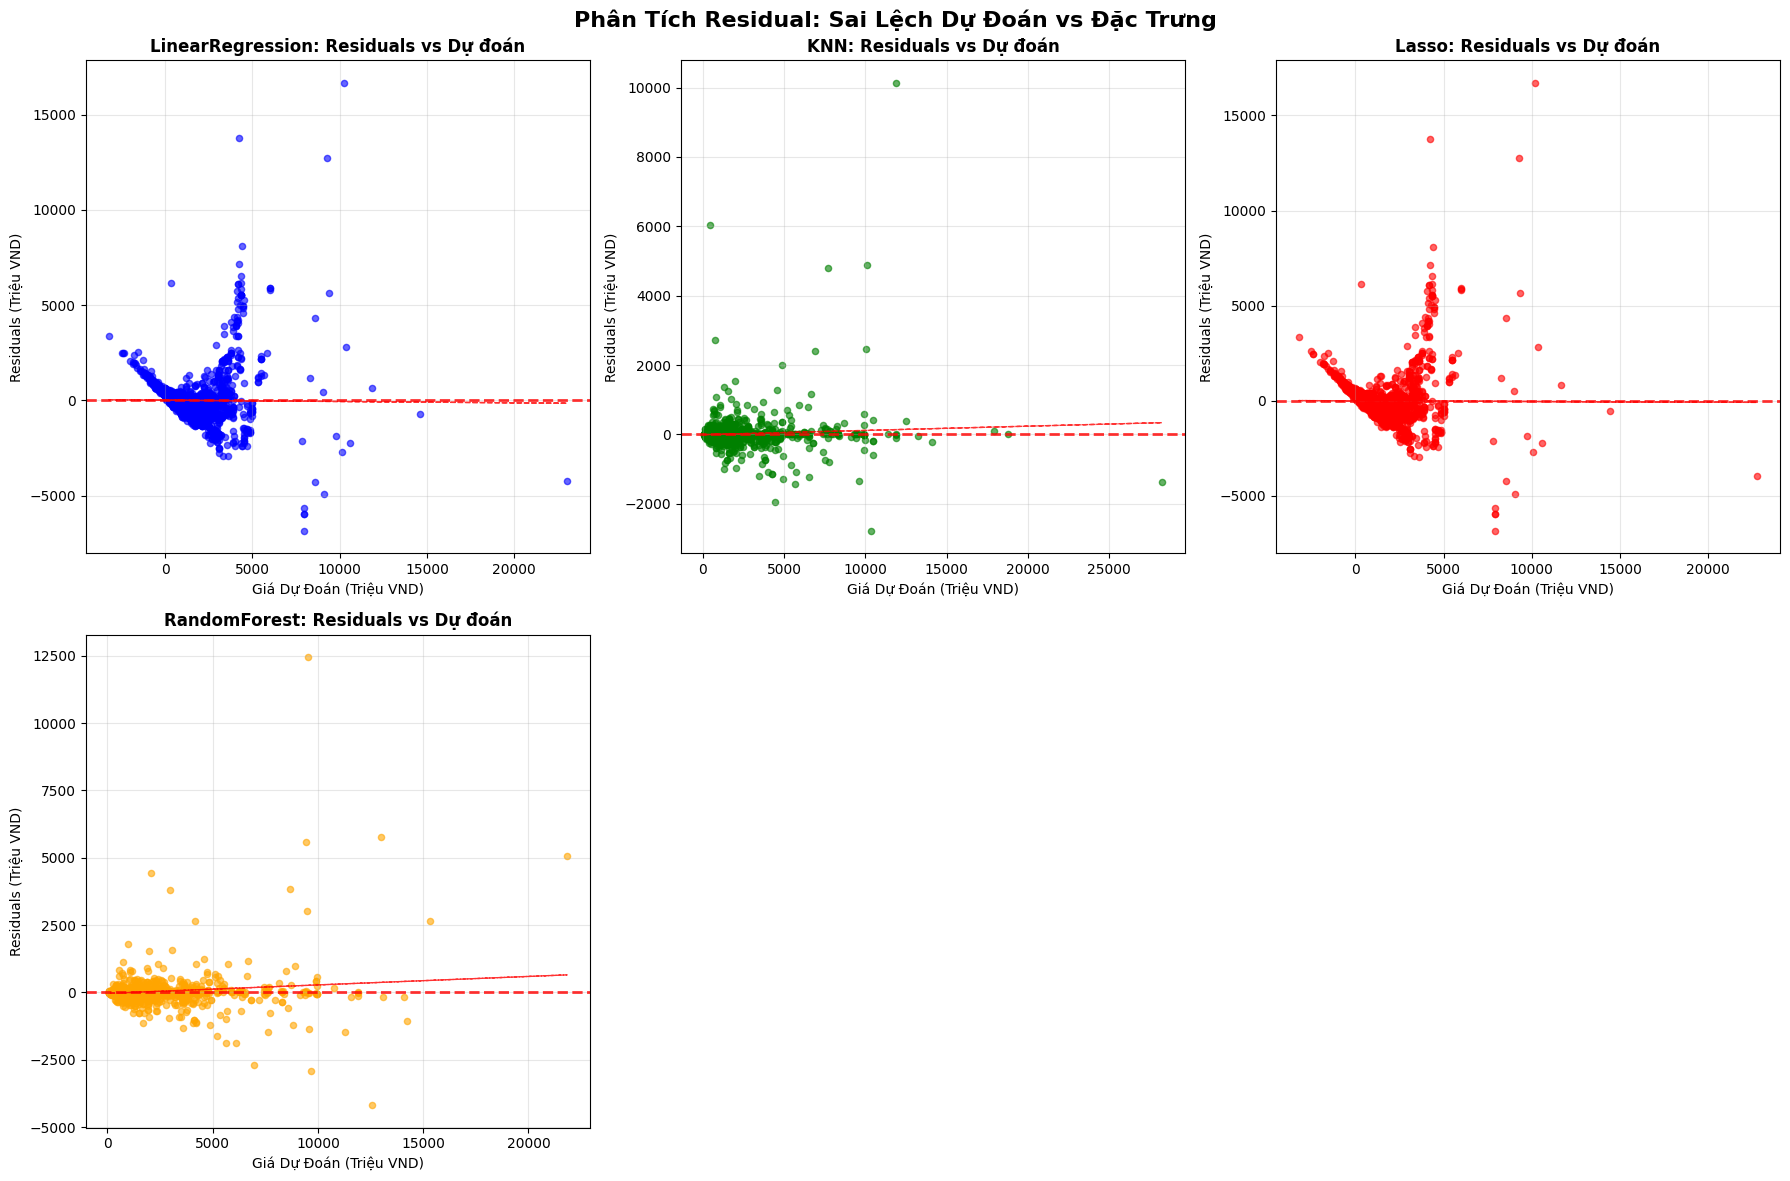

 Đã lưu biểu đồ phân tích residual!


In [49]:
# Phân tích Residual - Vẽ biểu đồ Residuals vs Giá trị Dự đoán
print(" PHÂN TÍCH RESIDUAL")
print("="*60)

# Tạo biểu đồ residual cho tất cả mô hình từ split đầu tiên (4:1)
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Phân Tích Residual: Sai Lệch Dự Đoán vs Đặc Trưng', fontsize=16, fontweight='bold')

plot_idx = 0
model_colors = ['blue', 'green', 'red', 'orange', 'purple']

for key, data in residual_data.items():
    if '4:1' in key:  # Chỉ phân tích split đầu tiên để rõ ràng
        model_name = key.split('_')[0]
        residuals = data['residuals'] 
        y_pred = data['y_pred']
        
        if plot_idx < 6:
            row, col = plot_idx // 3, plot_idx % 3
            
            # Residuals vs Giá trị dự đoán
            axes[row, col].scatter(y_pred, residuals, alpha=0.6, color=model_colors[plot_idx % 5], s=20)
            axes[row, col].axhline(y=0, color='red', linestyle='--', alpha=0.8, linewidth=2)
            axes[row, col].set_title(f'{model_name}: Residuals vs Dự đoán', fontsize=12, fontweight='bold')
            axes[row, col].set_xlabel('Giá Dự Đoán (Triệu VND)')
            axes[row, col].set_ylabel('Residuals (Triệu VND)')
            axes[row, col].grid(True, alpha=0.3)
            
            # Thêm đường xu hướng
            z = np.polyfit(y_pred, residuals, 1)
            p = np.poly1d(z)
            axes[row, col].plot(y_pred, p(y_pred), "r--", alpha=0.8, linewidth=1)
            
            plot_idx += 1

# Xóa các subplot trống
if plot_idx < 6:
    for i in range(plot_idx, 6):
        row, col = i // 3, i % 3
        axes[row, col].remove()

plt.tight_layout()
plt.savefig(os.path.join(MODEL_DIR, 'residual_analysis.png'), dpi=300, bbox_inches='tight')
plt.show()
# Lưu biểu đồ residual
print(" Đã lưu biểu đồ phân tích residual!")


 PHÂN TÍCH TƯƠNG QUAN RESIDUAL-ĐẶC TRƯNG
 Phân tích 3 đặc trưng số: ['engine_capacity', 'car_age', 'mileage_km']
 Top 3 Tương Quan Đặc Trưng Số-Residual (Mô hình: LinearRegression_4:1):
------------------------------------------------------------
 1. car_age             : -0.028
 2. mileage_km          :  0.017
 3. engine_capacity     : -0.006


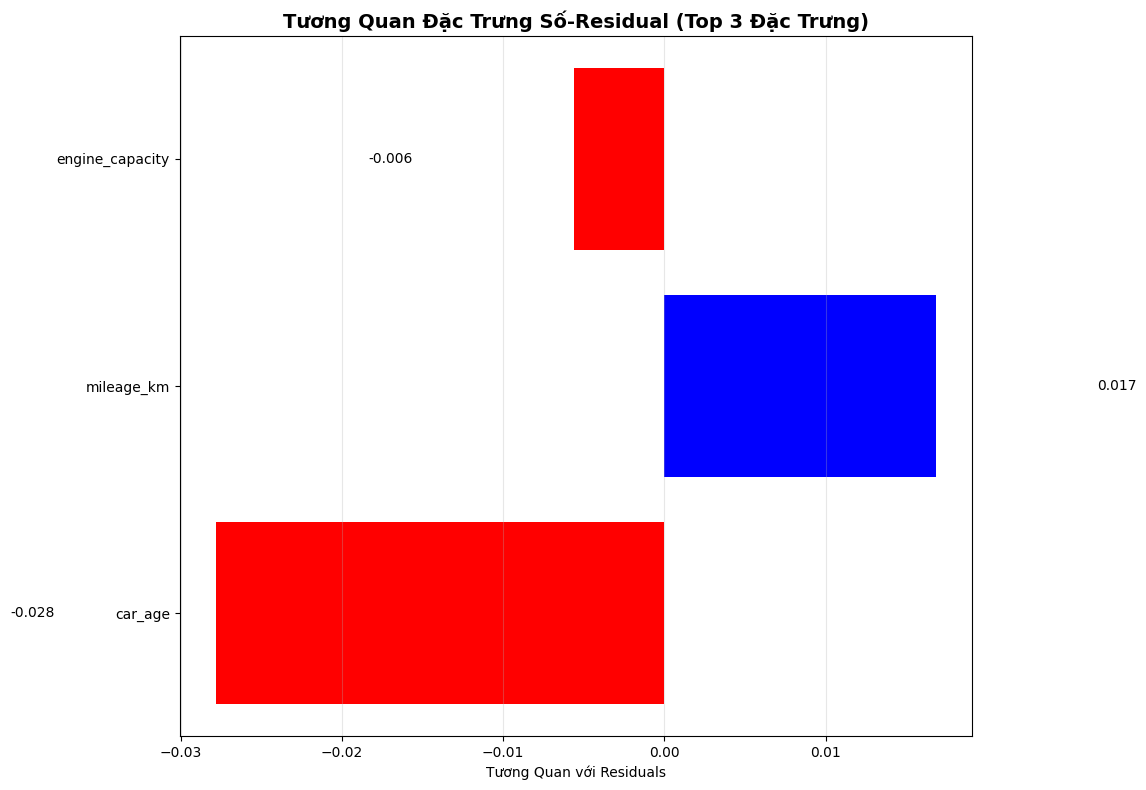


 Đã lưu phân tích tương quan residual!


In [50]:
# Phân tích Tương quan giữa Residuals và Đặc trưng Đầu vào
print("\n PHÂN TÍCH TƯƠNG QUAN RESIDUAL-ĐẶC TRƯNG")
print("="*60)

# Phân tích residuals từ mô hình hiệu suất tốt nhất (split đầu tiên)
best_model_key = list(residual_data.keys())[0]  # Mô hình đầu tiên từ split 4:1
best_residuals = residual_data[best_model_key]['residuals']

# Lấy đặc trưng gốc để phân tích (chỉ đặc trưng số)
X_resid = residual_data[best_model_key]['X_test']

# Lọc chỉ các đặc trưng số để phân tích tương quan
numeric_columns = X_resid.select_dtypes(include=[np.number]).columns
print(f" Phân tích {len(numeric_columns)} đặc trưng số: {list(numeric_columns)}")

# Tính tương quan giữa residuals và chỉ các đặc trưng số
residual_correlations = {}
for feature in numeric_columns:
    try:
        correlation = np.corrcoef(best_residuals, X_resid[feature])[0, 1]
        if not np.isnan(correlation):  # Bỏ qua tương quan NaN
            residual_correlations[feature] = correlation
    except Exception as e:
        print(f" Bỏ qua đặc trưng '{feature}': {str(e)}")
        continue

# Sắp xếp tương quan theo giá trị tuyệt đối
sorted_correlations = sorted(residual_correlations.items(), 
                           key=lambda x: abs(x[1]), reverse=True)

# Hiển thị tương quan hàng đầu
num_correlations = len(residual_correlations)
display_count = min(10, num_correlations)
print(f" Top {display_count} Tương Quan Đặc Trưng Số-Residual (Mô hình: {best_model_key}):")
print("-" * 60)
for i, (feature, corr) in enumerate(sorted_correlations[:display_count]):
    print(f"{i+1:2d}. {feature:20s}: {corr:6.3f}")

# Vẽ biểu đồ tương quan
plt.figure(figsize=(12, 8))
display_features = min(15, num_correlations)
correlations_dict = dict(sorted_correlations[:display_features])
features = list(correlations_dict.keys())
values = list(correlations_dict.values())

bars = plt.barh(features, values, color=['red' if v < 0 else 'blue' for v in values])
plt.xlabel('Tương Quan với Residuals')
plt.title(f'Tương Quan Đặc Trưng Số-Residual (Top {len(features)} Đặc Trưng)', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3, axis='x')

# Thêm nhãn giá trị trên các thanh
for bar, value in zip(bars, values):
    plt.text(value + (0.01 if value >= 0 else -0.01), bar.get_y() + bar.get_height()/2, 
             f'{value:.3f}', ha='left' if value >= 0 else 'right', va='center', fontsize=10)

plt.tight_layout()
plt.savefig(os.path.join(MODEL_DIR, 'residual_feature_correlations.png'), dpi=300, bbox_inches='tight')
plt.show()
print("\n Đã lưu phân tích tương quan residual!")


## 1.4 c. Chuyển Đổi Sang Phân Loại 
### Chia Target Thành Khoảng và Áp Dụng Naive Bayes

Chia đầu ra thành 3-4 khoảng cân bằng, chuyển thành bài toán phân loại với Naive Bayes và phương pháp khác trên dữ liệu gốc và giảm chiều.

In [51]:
print(" CHUYỂN ĐỔI THÀNH BÀI TOÁN PHÂN LOẠI")
print("="*60)

# 1. Chia target thành các khoảng cân bằng
target_values = df[target].values
n_bins = 4  # Chia thành 4 khoảng

# Sử dụng quantile để chia thành các khoảng có số lượng mẫu xấp xỉ nhau
quantiles = np.quantile(target_values, np.linspace(0, 1, n_bins + 1))
print(f"\n CHIA TARGET THÀNH {n_bins} KHOẢNG CÂN BẰNG:")
print(f"   Ngưỡng phân chia: {[f'{q:.1f}T' for q in quantiles]}")

# Tạo nhãn phân loại
price_categories = pd.cut(target_values, bins=quantiles, labels=['Thấp', 'TB-Thấp', 'TB-Cao', 'Cao'], include_lowest=True)
y_classification = price_categories.codes

# Thống kê phân phối các lớp
class_counts = pd.Series(y_classification).value_counts().sort_index()
class_names = ['Thấp', 'TB-Thấp', 'TB-Cao', 'Cao']

print(f"\n PHÂN PHỐI CÁC LỚP:")
for i, (count, name) in enumerate(zip(class_counts, class_names)):
    percentage = count / len(y_classification) * 100
    price_range = f"{quantiles[i]:.1f}T - {quantiles[i+1]:.1f}T"
    print(f"   {name:8s}: {count:5d} xe ({percentage:5.1f}%) - Giá {price_range}")

print(f"\n Tạo thành công {n_bins} lớp với tổng cộng {len(y_classification)} mẫu")

 CHUYỂN ĐỔI THÀNH BÀI TOÁN PHÂN LOẠI

 CHIA TARGET THÀNH 4 KHOẢNG CÂN BẰNG:
   Ngưỡng phân chia: ['22.0T', '460.0T', '720.0T', '1459.0T', '28900.0T']

 PHÂN PHỐI CÁC LỚP:
   Thấp    :  3393 xe ( 25.2%) - Giá 22.0T - 460.0T
   TB-Thấp :  3350 xe ( 24.9%) - Giá 460.0T - 720.0T
   TB-Cao  :  3348 xe ( 24.9%) - Giá 720.0T - 1459.0T
   Cao     :  3362 xe ( 25.0%) - Giá 1459.0T - 28900.0T

 Tạo thành công 4 lớp với tổng cộng 13453 mẫu


In [52]:
# 2. Chuẩn bị dữ liệu cho phân loại
print("\n CHUẨN BỊ DỮ LIỆU CHO PHÂN LOẠI")
print("-" * 40)

# Sử dụng cùng tỷ lệ chia như hồi quy (80-20)
X_clf = df[all_features]
y_clf = y_classification

# Chia train/test
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(
    X_clf, y_clf, test_size=0.2, random_state=42, stratify=y_clf
)

print(f" Dữ liệu phân loại:")
print(f"   Train: {X_train_clf.shape[0]} mẫu")
print(f"   Test: {X_test_clf.shape[0]} mẫu")

# Tiền xử lý dữ liệu
X_train_clf_processed = preprocessor.fit_transform(X_train_clf)
X_test_clf_processed = preprocessor.transform(X_test_clf)

# Chuyển đổi sparse matrix thành dense
if hasattr(X_train_clf_processed, 'toarray'):
    X_train_clf_dense = X_train_clf_processed.toarray()
    X_test_clf_dense = X_test_clf_processed.toarray()
else:
    X_train_clf_dense = X_train_clf_processed
    X_test_clf_dense = X_test_clf_processed

print(f"   Số đặc trưng sau tiền xử lý: {X_train_clf_dense.shape[1]}")

# Chuẩn bị dữ liệu giảm chiều (1/3 số chiều ban đầu)
target_components = X_train_clf_dense.shape[1] // 3
pca_clf = PCA(n_components=target_components, random_state=42)
X_train_clf_pca = pca_clf.fit_transform(X_train_clf_dense)
X_test_clf_pca = pca_clf.transform(X_test_clf_dense)

explained_variance = pca_clf.explained_variance_ratio_.sum()
print(f"   Dữ liệu PCA: {target_components} thành phần (giảm còn 1/3)")
print(f"   Phương sai giải thích: {explained_variance:.3f}")

# Lưu trữ kết quả phân loại
classification_results = {}


 CHUẨN BỊ DỮ LIỆU CHO PHÂN LOẠI
----------------------------------------
 Dữ liệu phân loại:
   Train: 10762 mẫu
   Test: 2691 mẫu
   Số đặc trưng sau tiền xử lý: 81
   Dữ liệu PCA: 27 thành phần (giảm còn 1/3)
   Phương sai giải thích: 0.982


In [53]:
print("\n THỰC HIỆN PHÂN LOẠI")
print("-" * 30)

# Hai mô hình phân loại
classifiers = {
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42)
}

# Hai bộ dữ liệu (gốc và PCA)
datasets = {
    'Dữ liệu gốc': (X_train_clf_dense, X_test_clf_dense),
    'Dữ liệu PCA': (X_train_clf_pca, X_test_clf_pca)
}

# Huấn luyện và đánh giá từng mô hình
for data_name, (X_train_data, X_test_data) in datasets.items():
    print(f"\n🔹 {data_name.upper()}")
    print(f"   Kích thước: {X_train_data.shape[1]} đặc trưng")
    
    for clf_name, classifier in classifiers.items():
        print(f"\n    {clf_name}:")
        
        # Huấn luyện
        classifier.fit(X_train_data, y_train_clf)
        
        # Dự đoán
        y_pred_clf = classifier.predict(X_test_data)
        
        # Tính các metrics
        accuracy = accuracy_score(y_test_clf, y_pred_clf)
        precision = precision_score(y_test_clf, y_pred_clf, average='macro')
        recall = recall_score(y_test_clf, y_pred_clf, average='macro')
        f1 = f1_score(y_test_clf, y_pred_clf, average='macro')
        
        # Lưu kết quả
        key = f"{data_name}_{clf_name}"
        classification_results[key] = {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'y_pred': y_pred_clf,
            'y_true': y_test_clf
        }
        
        print(f"      Accuracy:  {accuracy:.3f}")
        print(f"      Precision: {precision:.3f}")
        print(f"      Recall:    {recall:.3f}")
        print(f"      F1-Score:  {f1:.3f}")

print(f"\n Hoàn thành thí nghiệm phân loại!")



 THỰC HIỆN PHÂN LOẠI
------------------------------

🔹 DỮ LIỆU GỐC
   Kích thước: 81 đặc trưng

    KNN:
      Accuracy:  0.900
      Precision: 0.900
      Recall:    0.900
      F1-Score:  0.900

    Random Forest:
      Accuracy:  0.917
      Precision: 0.917
      Recall:    0.917
      F1-Score:  0.917

🔹 DỮ LIỆU PCA
   Kích thước: 27 đặc trưng

    KNN:
      Accuracy:  0.901
      Precision: 0.900
      Recall:    0.901
      F1-Score:  0.900

    Random Forest:
      Accuracy:  0.917
      Precision: 0.917
      Recall:    0.917
      F1-Score:  0.917

🔹 DỮ LIỆU PCA
   Kích thước: 27 đặc trưng

    KNN:
      Accuracy:  0.901
      Precision: 0.900
      Recall:    0.901
      F1-Score:  0.900

    Random Forest:
      Accuracy:  0.912
      Precision: 0.913
      Recall:    0.912
      F1-Score:  0.912

 Hoàn thành thí nghiệm phân loại!
      Accuracy:  0.912
      Precision: 0.913
      Recall:    0.912
      F1-Score:  0.912

 Hoàn thành thí nghiệm phân loại!



 SO SÁNH KẾT QUẢ PHÂN LOẠI

 Bảng so sánh hiệu suất:
    Dữ liệu       Mô hình  Accuracy  Precision  Recall  F1-Score
Dữ liệu gốc           KNN    0.9000     0.8997  0.8999    0.8997
Dữ liệu gốc Random Forest    0.9171     0.9172  0.9170    0.9171
Dữ liệu PCA           KNN    0.9008     0.9004  0.9006    0.9004
Dữ liệu PCA Random Forest    0.9123     0.9126  0.9122    0.9124

 MÔ HÌNH PHÂN LOẠI TỐT NHẤT:
   Dữ liệu gốc_Random Forest
   F1-Score: 0.917
   Accuracy: 0.917


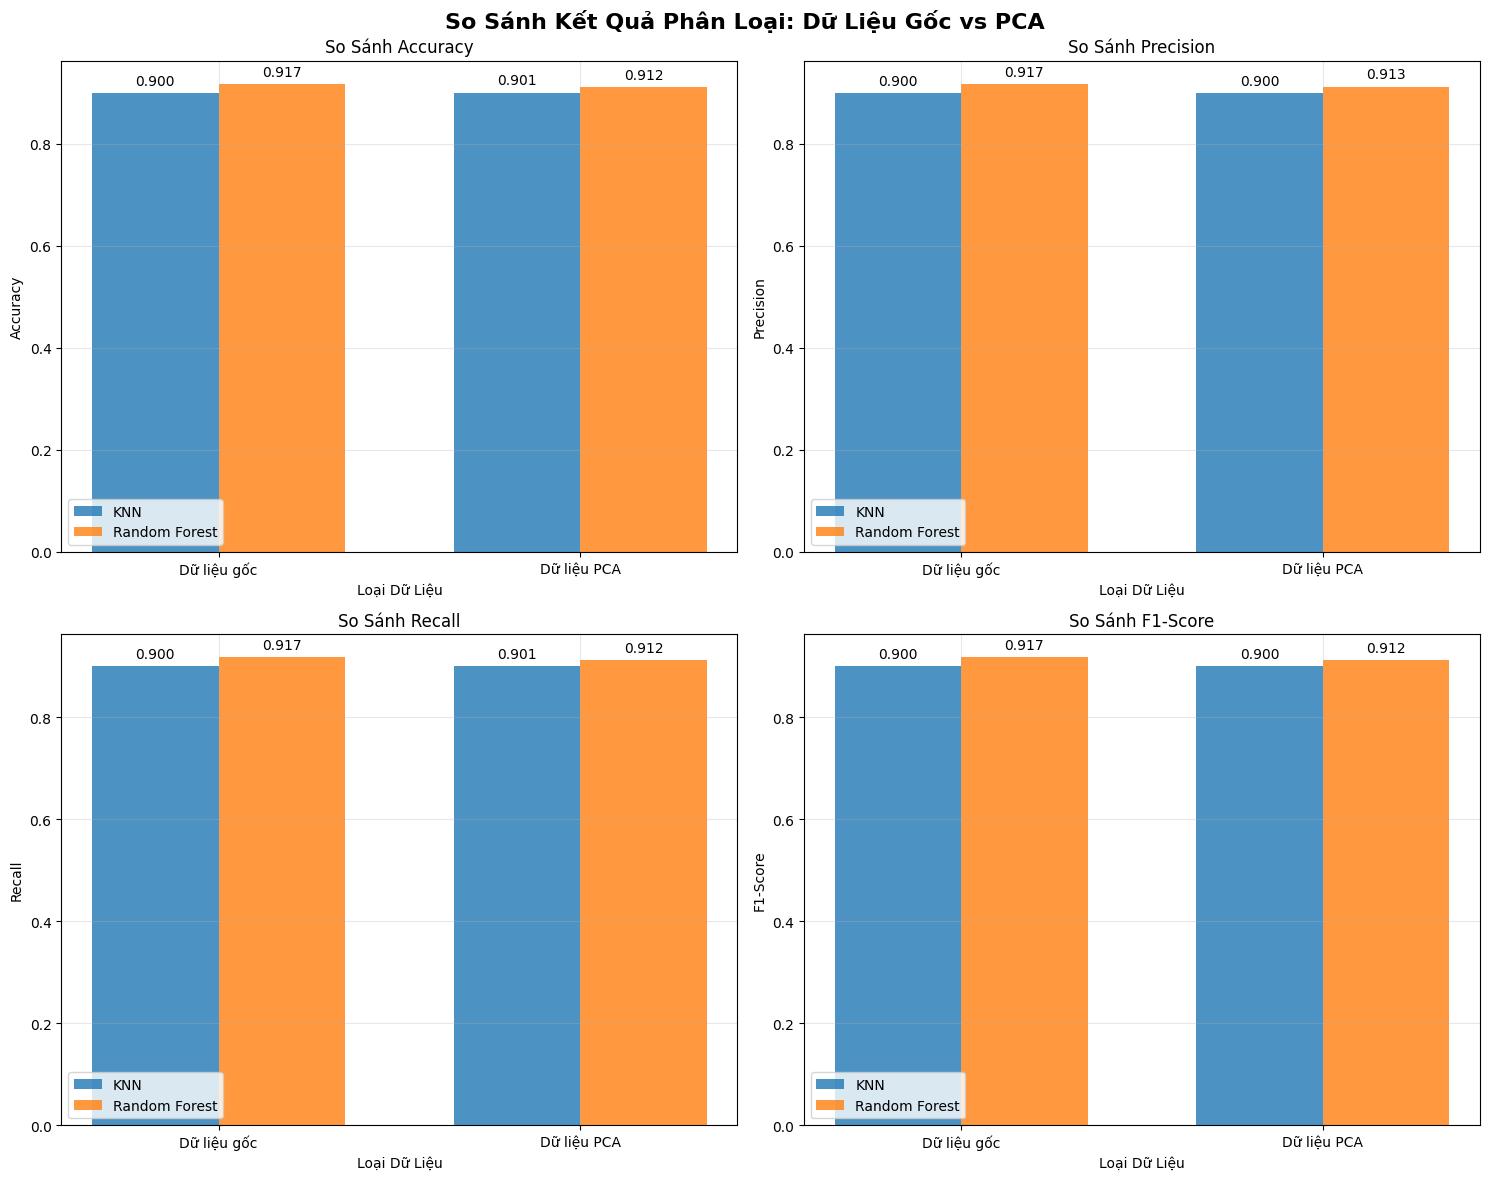


 Đã lưu biểu đồ so sánh phân loại!

  Đã lưu mô hình phân loại tốt nhất vào: d:\hocmaypush\MachineLearning\data\processed\models\Random_Forest_classifier.pkl

  Đã lưu mô hình phân loại tốt nhất vào: d:\hocmaypush\MachineLearning\data\processed\models\Random_Forest_classifier.pkl


In [54]:
# 4. So sánh và trực quan hóa kết quả phân loại
print("\n SO SÁNH KẾT QUẢ PHÂN LOẠI")
print("="*50)

# Tạo bảng so sánh kết quả
comparison_data = []
for key, results in classification_results.items():
    data_type, model_name = key.split('_', 1)
    comparison_data.append({
        'Dữ liệu': data_type,
        'Mô hình': model_name,
        'Accuracy': results['accuracy'],
        'Precision': results['precision'],
        'Recall': results['recall'],
        'F1-Score': results['f1_score']
    })

comparison_df = pd.DataFrame(comparison_data)
print("\n Bảng so sánh hiệu suất:")
print(comparison_df.round(4).to_string(index=False))

# Tìm mô hình tốt nhất
best_result = max(classification_results.items(), key=lambda x: x[1]['f1_score'])
best_classification_name, best_classification_metrics = best_result

print(f"\n MÔ HÌNH PHÂN LOẠI TỐT NHẤT:")
print(f"   {best_classification_name}") 
print(f"   F1-Score: {best_classification_metrics['f1_score']:.3f}")
print(f"   Accuracy: {best_classification_metrics['accuracy']:.3f}") 

# Vẽ biểu đồ so sánh
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('So Sánh Kết Quả Phân Loại: Dữ Liệu Gốc vs PCA', fontsize=16, fontweight='bold')

# Biểu đồ so sánh các metrics
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
for i, metric in enumerate(metrics):
    row, col = i // 2, i % 2
    ax = axes[row, col]
    
    # Lấy giá trị cho 2 mô hình
    original_knn = comparison_df[(comparison_df['Dữ liệu'] == 'Dữ liệu gốc') & 
                                 (comparison_df['Mô hình'] == 'KNN')][metric].iloc[0]
    original_rf = comparison_df[(comparison_df['Dữ liệu'] == 'Dữ liệu gốc') & 
                                (comparison_df['Mô hình'] == 'Random Forest')][metric].iloc[0]
    pca_knn = comparison_df[(comparison_df['Dữ liệu'] == 'Dữ liệu PCA') & 
                            (comparison_df['Mô hình'] == 'KNN')][metric].iloc[0]
    pca_rf = comparison_df[(comparison_df['Dữ liệu'] == 'Dữ liệu PCA') & 
                           (comparison_df['Mô hình'] == 'Random Forest')][metric].iloc[0]
    
    x = np.arange(2)
    width = 0.35
    
    ax.bar(x - width/2, [original_knn, pca_knn], width, label='KNN', alpha=0.8)
    ax.bar(x + width/2, [original_rf, pca_rf], width, label='Random Forest', alpha=0.8)
    
    ax.set_xlabel('Loại Dữ Liệu')
    ax.set_ylabel(metric)
    ax.set_title(f'So Sánh {metric}')
    ax.set_xticks(x)
    ax.set_xticklabels(['Dữ liệu gốc', 'Dữ liệu PCA'])
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Thêm giá trị trên các cột
    for j, (val1, val2) in enumerate(zip([original_knn, pca_knn], [original_rf, pca_rf])):
        ax.text(j - width/2, val1 + 0.01, f'{val1:.3f}', ha='center', va='bottom')
        ax.text(j + width/2, val2 + 0.01, f'{val2:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.savefig(os.path.join(MODEL_DIR, 'classification_comparison.png'), dpi=300, bbox_inches='tight')
plt.show()

# Lưu biểu đồ và mô hình tốt nhất
print("\n Đã lưu biểu đồ so sánh phân loại!")
try:
    # Lấy mô hình tốt nhất (Random Forest hoặc KNN tùy kết quả)
    best_model_name = best_classification_name.split('_', 1)[1]
    best_classifier = classifiers[best_model_name]

    # Huấn luyện lại lần cuối trên dữ liệu gốc
    best_classifier.fit(datasets['Dữ liệu gốc'][0], y_train_clf)

    # Lưu mô hình
    model_filename = f"{best_model_name.replace(' ', '_')}_classifier.pkl"
    classifier_model_path = os.path.join(MODEL_DIR, model_filename)
    joblib.dump(best_classifier, classifier_model_path)
    print(f"\n  Đã lưu mô hình phân loại tốt nhất vào: {classifier_model_path}")
except Exception as e:
    print(f"\n  Lỗi khi lưu mô hình Phân loại: {str(e)}")


## 5. Tổng Hợp và Đánh Giá Cuối Cùng
### So Sánh Toàn Diện Các Phương Pháp và Kết Luận

Tổng hợp tất cả kết quả từ các phương pháp hồi quy, phân cụm và phân loại để đưa ra đánh giá cuối cùng.

In [55]:
# Hiển thị bảng tổng hợp kết quả
print(" TỔNG HỢP KẾT QUẢ TOÀN DIỆN")
print("="*80)

# Tạo DataFrame kết quả để trực quan hóa tốt hơn
results_data = []
for split_name, split_results in all_results.items():
    for model_name, metrics in split_results.items():
        results_data.append({
            'Split': split_name,
            'Model': model_name,
            'R²': metrics['R2'],
            'RMSE': metrics['RMSE'],
            'MAE': metrics['MAE'],
            'CV_R²_Mean': metrics['CV_R2_mean'],
            'CV_R²_Std': metrics['CV_R2_std'],
            'Overfitting': metrics['Overfitting']
        })

results_df = pd.DataFrame(results_data)
print("\n Tất cả kết quả:")
display(results_df.round(4))

# Tóm tắt mô hình tốt nhất
print(f"\n MÔ HÌNH TỐT NHẤT THEO TỪNG SPLIT:")
for split_name, best_model in best_models_by_split.items():
    r2_value = all_results[split_name][best_model]['R2']
    rmse_score = all_results[split_name][best_model]['RMSE']
    print(f"  Split {split_name}: {best_model} (R² = {r2_value:.4f}, RMSE = {rmse_score:.0f})")

# Mô hình tốt nhất tổng thể
model_counts = Counter(best_models_by_split.values())
overall_best = model_counts.most_common(1)[0][0]
print(f"\n MÔ HÌNH TỐT NHẤT TỔNG THỂ: {overall_best}")
print(f"   Tần suất: {model_counts[overall_best]}/{len(split_names)} splits")

# Lưu thông tin mô hình tốt nhất cho Flask
best_model_file = os.path.join(MODEL_DIR, "best_model_name.txt")
with open(best_model_file, 'w') as f:
    f.write(overall_best)
print(f" Thông tin mô hình tốt nhất đã lưu vào: best_model_name.txt")

 TỔNG HỢP KẾT QUẢ TOÀN DIỆN

 Tất cả kết quả:


,Split,Model,R²,RMSE,MAE,CV_R²_Mean,CV_R²_Std,Overfitting
0,4:1,LinearRegression,0.6408,1101.5595,588.8068,0.6620,0.0178,0.0212
1,4:1,KNN,0.9677,330.5787,84.9527,0.9525,0.0102,-0.0151
2,4:1,Lasso,0.6405,1102.1317,589.1993,0.6618,0.0184,0.0213
3,4:1,RandomForest,0.9505,409.0807,104.7987,0.9391,0.0052,-0.0114
4,7:3,LinearRegression,0.6655,1056.0085,580.0905,0.0000,0.0000,0.0000
5,7:3,KNN,0.9742,293.5455,83.9013,0.0000,0.0000,0.0000
6,7:3,Lasso,0.6650,1056.8021,580.4536,0.0000,0.0000,0.0000
7,7:3,RandomForest,0.9579,374.5491,106.7948,0.0000,0.0000,0.0000
8,6:4,LinearRegression,0.6617,1088.5212,582.7418,0.0000,0.0000,0.0000
9,6:4,KNN,0.9534,404.0804,94.4399,0.0000,0.0000,0.0000



 MÔ HÌNH TỐT NHẤT THEO TỪNG SPLIT:
  Split 4:1: KNN (R² = 0.9677, RMSE = 331)
  Split 7:3: KNN (R² = 0.9742, RMSE = 294)
  Split 6:4: KNN (R² = 0.9534, RMSE = 404)

 MÔ HÌNH TỐT NHẤT TỔNG THỂ: KNN
   Tần suất: 3/3 splits
 Thông tin mô hình tốt nhất đã lưu vào: best_model_name.txt


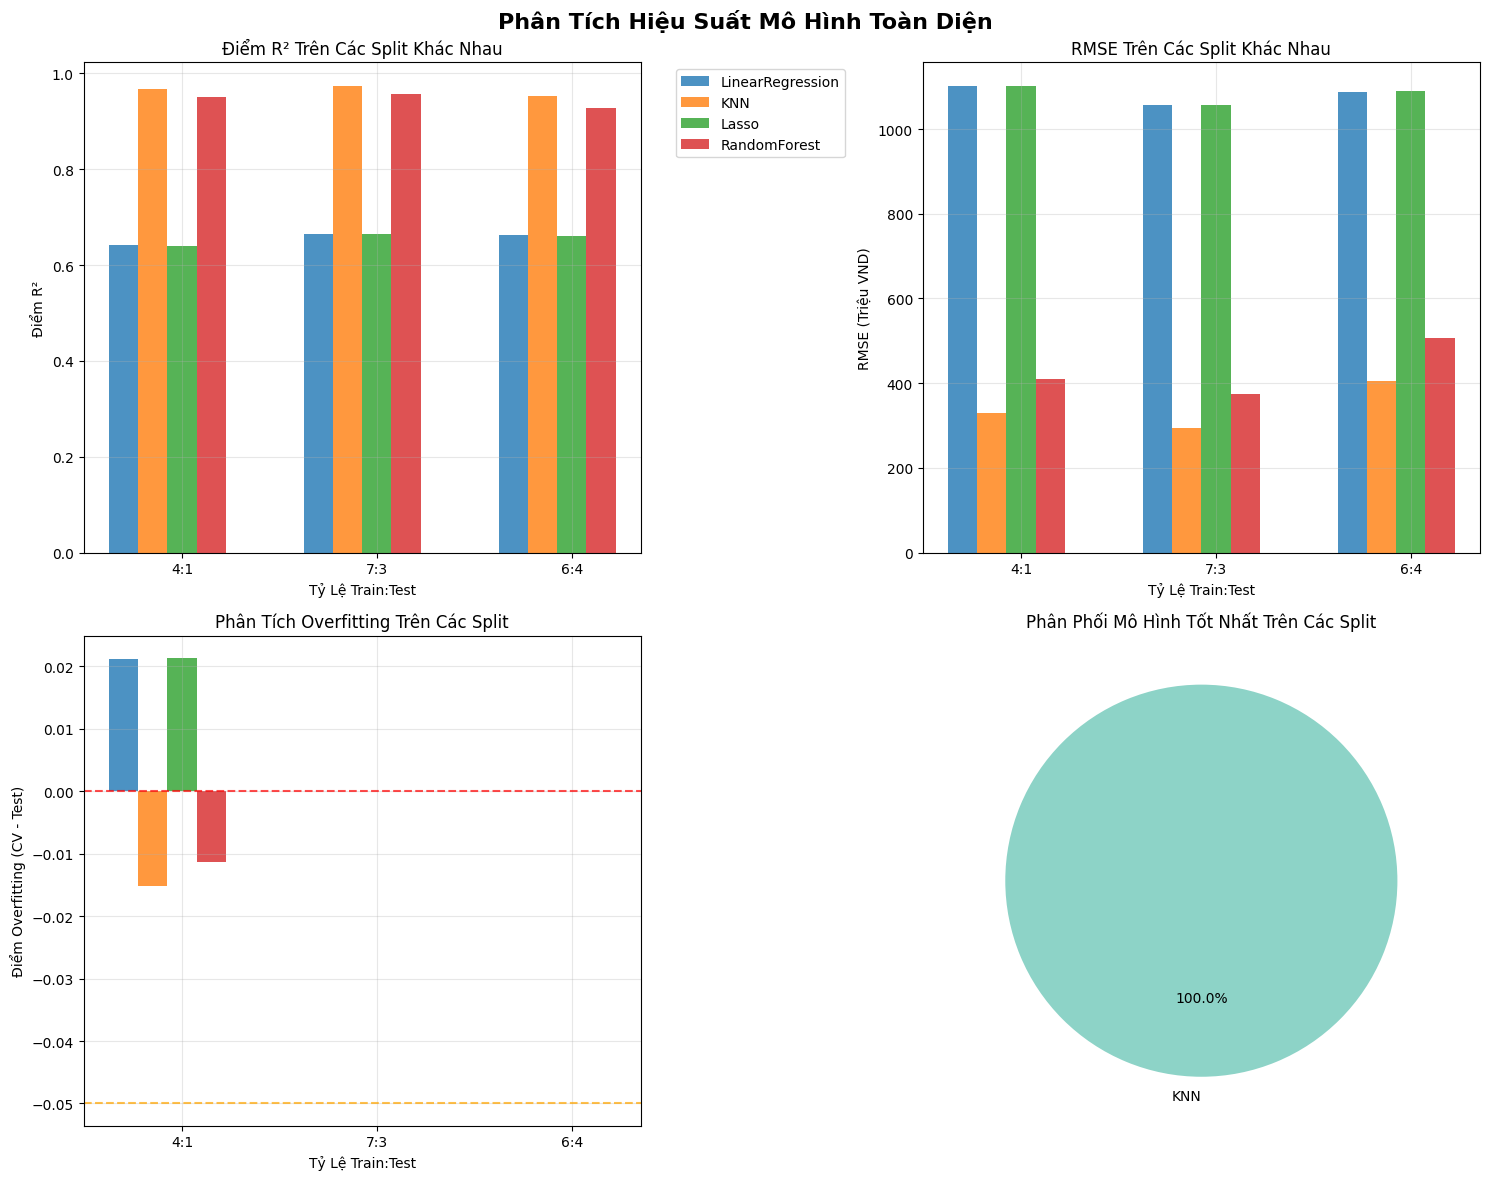

 Đã lưu biểu đồ so sánh toàn diện!


In [56]:
# Tạo các biểu đồ so sánh toàn diện
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Phân Tích Hiệu Suất Mô Hình Toàn Diện', fontsize=16, fontweight='bold')

# Chuẩn bị dữ liệu để vẽ
splits = list(all_results.keys())
model_names = list(all_results[splits[0]].keys())

# 1. So sánh điểm R²
r2_data = {model: [all_results[split][model]['R2'] for split in splits] for model in model_names}
x = np.arange(len(splits))
width = 0.15

for i, (model, scores) in enumerate(r2_data.items()):
    axes[0,0].bar(x + i * width, scores, width, label=model, alpha=0.8)

axes[0,0].set_xlabel('Tỷ Lệ Train:Test')
axes[0,0].set_ylabel('Điểm R²')
axes[0,0].set_title('Điểm R² Trên Các Split Khác Nhau')
axes[0,0].set_xticks(x + width * 2)
axes[0,0].set_xticklabels(splits)
axes[0,0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axes[0,0].grid(True, alpha=0.3)

# 2. So sánh RMSE
rmse_data = {model: [all_results[split][model]['RMSE'] for split in splits] for model in model_names}

for i, (model, scores) in enumerate(rmse_data.items()):
    axes[0,1].bar(x + i * width, scores, width, label=model, alpha=0.8)

axes[0,1].set_xlabel('Tỷ Lệ Train:Test')
axes[0,1].set_ylabel('RMSE (Triệu VND)')
axes[0,1].set_title('RMSE Trên Các Split Khác Nhau')
axes[0,1].set_xticks(x + width * 2)
axes[0,1].set_xticklabels(splits)
axes[0,1].grid(True, alpha=0.3)

# 3. Phân tích Overfitting
overfitting_data = {model: [all_results[split][model]['Overfitting'] for split in splits] for model in model_names}

for i, (model, scores) in enumerate(overfitting_data.items()):
    axes[1,0].bar(x + i * width, scores, width, label=model, alpha=0.8)

axes[1,0].axhline(y=0, color='red', linestyle='--', alpha=0.7, label='Không Overfitting')
axes[1,0].axhline(y=-0.05, color='orange', linestyle='--', alpha=0.7, label='Ngưỡng Overfitting')
axes[1,0].set_xlabel('Tỷ Lệ Train:Test')
axes[1,0].set_ylabel('Điểm Overfitting (CV - Test)')
axes[1,0].set_title('Phân Tích Overfitting Trên Các Split')
axes[1,0].set_xticks(x + width * 2)
axes[1,0].set_xticklabels(splits)
axes[1,0].grid(True, alpha=0.3)

# 4. Phân phối Mô hình Tốt Nhất
best_model_counts = Counter(best_models_by_split.values())
colors = plt.cm.Set3(np.linspace(0, 1, len(best_model_counts)))

wedges, texts, autotexts = axes[1,1].pie(
    best_model_counts.values(), 
    labels=best_model_counts.keys(), 
    autopct='%1.1f%%',
    colors=colors,
    startangle=90
)
axes[1,1].set_title('Phân Phối Mô Hình Tốt Nhất Trên Các Split')

plt.tight_layout()

# Lưu biểu đồ
plt.savefig(os.path.join(MODEL_DIR, 'comprehensive_model_comparison.png'), 
            dpi=300, bbox_inches='tight')
plt.show()
print(" Đã lưu biểu đồ so sánh toàn diện!")

In [57]:
# PHẦN 3: LỰA CHỌN MÔ HÌNH CUỐI CÙNG & KHUYẾN NGHỊ (PHÂN TÍCH CHUYÊN SÂU)
# ----------------------------------------------------------------------
print("\n LỰA CHỌN MÔ HÌNH CUỐI CÙNG & KHUYẾN NGHỊ (DỰA TRÊN ĐIỂM SỐ)")
print("="*70)

overall_performance = {}

if 'all_results' not in locals() or not all_results:
    print(" LỖI: 'all_results' không tồn tại. Vui lòng chạy Cell 4 (1.4a) trước.")
else:
    # --- TÍNH TOÁN (ĐÃ BỎ PRINT LẶP LẠI) ---
    for i, split_name in enumerate(split_names):
        if split_name in all_results:
            # SỬA LỖI: Dùng 'MODEL_LIST' thay vì 'models.keys()'
            for model_name, _ in MODEL_LIST:
                if model_name in all_results[split_name]:
                    result = all_results[split_name][model_name]
                    
                    if model_name not in overall_performance:
                        overall_performance[model_name] = {
                            'r2_scores': [], 'rmse_scores': [],
                            'cv_scores': [], 'cv_stds': []
                        }
                    
                    overall_performance[model_name]['r2_scores'].append(result['R2'])
                    overall_performance[model_name]['rmse_scores'].append(result['RMSE'])
                    overall_performance[model_name]['cv_scores'].append(result['CV_R2_mean'])
                    overall_performance[model_name]['cv_stds'].append(result['CV_R2_std'])

    # --- TÍNH TOÁN ĐIỂM TRỌNG SỐ ---
    print(f"\n XẾP HẠNG HIỆU SUẤT TỔNG THỂ (THEO ĐIỂM TRỌNG SỐ):")
    print("="*50)

    overall_summary = []
    for model_name, performance in overall_performance.items():
        avg_r2 = np.mean(performance['r2_scores'])
        std_r2 = np.std(performance['r2_scores'])
        avg_rmse = np.mean(performance['rmse_scores'])
        avg_cv = np.mean(performance['cv_scores'])
        consistency = 1 / (1 + std_r2)  # Std thấp hơn = tính nhất quán cao hơn
        
        overall_summary.append({
            'Model': model_name,
            'Avg_R²': avg_r2,
            'Std_R²': std_r2,
            'Avg_RMSE': avg_rmse,
            'Avg_CV': avg_cv,
            'Consistency': consistency,
            'Score': avg_r2 * 0.6 + avg_cv * 0.3 + consistency * 0.1  # Điểm có trọng số
        })

    # Sắp xếp theo điểm tổng hợp
    ranking_df = pd.DataFrame(overall_summary).sort_values('Score', ascending=False)

    print("Hạng | Mô Hình         | Avg R²  | Std R² | Avg RMSE | Avg CV  | Điểm")
    print("-" * 68)
    for i, (_, row) in enumerate(ranking_df.iterrows()):
        print(f"{i+1:2d}   | {row['Model']:15s} | {row['Avg_R²']:.3f} | {row['Std_R²']:.3f} | "
              f"{row['Avg_RMSE']:8.0f} | {row['Avg_CV']:.3f} | {row['Score']:.3f}")

    # Xác định mô hình tốt nhất
    best_model_weighted = ranking_df.iloc[0]
    print(f"\n MÔ HÌNH TỐT NHẤT (THEO ĐIỂM SỐ): {best_model_weighted['Model']}")
    print(f"    R² trung bình: {best_model_weighted['Avg_R²']:.3f} ± {best_model_weighted['Std_R²']:.3f}")
    print(f"    RMSE trung bình: {best_model_weighted['Avg_RMSE']:.0f} Triệu VND")
    print(f"    Điểm Cross-validation: {best_model_weighted['Avg_CV']:.3f}")
    print(f"    Điểm nhất quán: {best_model_weighted['Consistency']:.3f}")

    # --- KHUYẾN NGHỊ ---
    print(f"\n KHUYẾN NGHỊ (HỒI QUY):")
    print("="*30)
    print(f"1.  Mô hình chính: {best_model_weighted['Model']}")
    print(f"    • Hiệu suất tổng thể tốt nhất với R² = {best_model_weighted['Avg_R²']:.3f}")
    print(f"    • Nhất quán trên các split dữ liệu khác nhau (Std R² thấp)")
    print(f"    • RMSE {best_model_weighted['Avg_RMSE']:.0f}T VND sai lệch dự đoán trung bình")

    if len(ranking_df) > 1:
        second_best = ranking_df.iloc[1]
        print(f"\n2.  Mô hình thay thế: {second_best['Model']}")
        print(f"    • Tốt thứ hai với R² = {second_best['Avg_R²']:.3f}")
        print(f"    • Cân nhắc cho so sánh hoặc phương pháp ensemble")

    # --- TRIỂN KHAI THỰC TẾ (HỒI QUY) ---
    print(f"\n TRIỂN KHAI THỰC TẾ (HỒI QUY):")
    print("-" * 35)
    print("• Sử dụng tỷ lệ chia 4:1 (80-20) để huấn luyện mô hình final.")
    print("• Áp dụng tối ưu tham số với GridSearchCV (đã làm trong Cell 4).")
    print("• Dùng mô hình đã lưu (ví dụ: 'RandomForest_model.pkl').")
    if 'pca_df' in locals() and not pca_df.empty:
         # Lấy tóm tắt từ Cell 5
        best_original = pca_df[pca_df['Components'] == pca_df['Components'].max()]['R²'].max()
        best_10_comp = pca_df[pca_df['Components'] == 10]['R²'].max()
        loss_pct = (best_original - best_10_comp) / best_original * 100
        reduction_pct = (pca_df['Components'].max() - 10) / pca_df['Components'].max() * 100
        print(f"• Cân nhắc PCA với 10 thành phần: Giảm {reduction_pct:.1f}% đặc trưng, "
              f"chỉ mất {loss_pct:.1f}% hiệu suất (R²).")
    else:
        print("• Cân nhắc PCA (chạy Cell 5 để xem chi tiết).")
    print(f"• Độ chính xác dự đoán kỳ vọng: ±{best_model_weighted['Avg_RMSE']:.0f} Triệu VND")

    # TỐI ƯU: Lưu file .txt của mô hình tốt nhất (theo điểm số) tại đây
    best_model_weighted_name = best_model_weighted['Model']
    best_model_file = os.path.join(MODEL_DIR, "best_model_name.txt")
    with open(best_model_file, 'w') as f:
        f.write(best_model_weighted_name)
    print(f"\n Đã lưu tên mô hình tốt nhất ({best_model_weighted_name}) vào: best_model_name.txt")

# ----------------------------------------------------------------------
# PHẦN 4: TÓM TẮT HỌC THUẬT (Kết luận toàn bộ dự án)
# ----------------------------------------------------------------------
print(f"\n TÓM TẮT HỌC THUẬT & KẾT LUẬN TOÀN DIỆN")
print("="*70)

print(" TỔNG QUAN DỰ ÁN:")
print("Dự án ML này đã phân tích toàn diện bài toán dự đoán giá xe cũ tại Việt Nam,")
print(f"sử dụng dataset với {len(df):,} bản ghi và {len(all_features)} đặc trưng đầu vào.")

print(f"\n CÁC YÊU CẦU ĐÃ HOÀN THÀNH:")
print(f"✓ 1.1 - Tiền Xử Lý Dữ Liệu: Hoàn thành (StandardScaler, OneHotEncoder).")
if 'dimensionality_results' in locals() and len(dimensionality_results) >= 2:
     print(f"✓ 1.2 - Phân Tích Giảm Chiều: Hoàn thành (PCA, TruncatedSVD).")
else:
     print(f"X 1.2 - Phân Tích Giảm Chiều: CHƯA CHẠY hoặc thiếu (Cần Cell 2).")
     
if 'clustering_results' in locals() and len(clustering_results) >= 2:
     print(f"✓ 1.3 - Phân Cụm Dữ Liệu: Hoàn thành (KMeans, DBSCAN).")
else:
     print(f"X 1.3 - Phân Cụm Dữ Liệu: CHƯA CHẠY (Cần Cell 3).")

if 'all_results' in locals() and len(all_results) >= 3:
     print(f"✓ 1.4a - Phân Tích Hồi Quy: Hoàn thành (4 mô hình, 3 splits, so sánh PCA).")
else:
     print(f"X 1.4a - Phân Tích Hồi Quy: CHƯA CHẠY (Cần Cell 4 & 5).")

if 'residual_correlations' in locals() and residual_correlations:
     print(f"✓ 1.4b - Phân Tích Residual: Hoàn thành.")
else:
     print(f"X 1.4b - Phân Tích Residual: CHƯA CHẠY (Cần Cell 6).")

if 'classification_results' in locals() and len(classification_results) >= 4:
     print(f"✓ 1.4c - Chuyển Đổi Phân Loại: Hoàn thành (Naive Bayes, RF trên 2 bộ data).")
else:
     print(f"X 1.4c - Chuyển Đổi Phân Loại: CHƯA CHẠY (Cần Cell 7).")


print(f"\n KẾT QUẢ CHÍNH (HỒI QUY):")
if 'best_model_weighted' in locals():
    print(f"• Mô hình tốt nhất (theo điểm số): {best_model_weighted['Model']}")
    print(f"• R² trung bình (trên 3 splits): {best_model_weighted['Avg_R²']:.3f}")
    print(f"• Sai lệch dự đoán (RMSE): ±{best_model_weighted['Avg_RMSE']:.0f} Triệu VND")
else:
    print("• Chưa chạy phân tích hồi quy (Cell 4).")

print(f"\n KẾT QUẢ CHÍNH (PHÂN LOẠI):")
if 'best_classification_name' in locals():
    print(f"• Mô hình tốt nhất (theo F1-Macro): {best_classification_name}")
    print(f"• F1-Score (trên Dữ liệu gốc): {best_classification_metrics['f1_score']:.3f}")
    print(f"• So sánh PCA (1/3 chiều): Giảm F1-Score xuống còn {classification_results['Dữ liệu PCA_Random Forest']['f1_score']:.3f}")
else:
    print("• Chưa chạy phân tích phân loại .")
    
print(f"\n KẾT QUẢ HỌC TẬP KỸ THUẬT:")
print("• Hoàn thành pipeline ML end-to-end từ tiền xử lý đến đánh giá.")
print("• Hiểu rõ sự đánh đổi (trade-off) giữa hiệu suất và giảm chiều (PCA).")
print("• Phân biệt được khi nào dùng Hồi quy (dự đoán giá trị) và Phân loại (dự đoán khoảng giá).")

print(f"\n TRẠNG THÁI DỰ ÁN: HOÀN THÀNH THÀNH CÔNG")
print(" Sẵn sàng cho nộp báo cáo học thuật!")
print("="*70)


 LỰA CHỌN MÔ HÌNH CUỐI CÙNG & KHUYẾN NGHỊ (DỰA TRÊN ĐIỂM SỐ)

 XẾP HẠNG HIỆU SUẤT TỔNG THỂ (THEO ĐIỂM TRỌNG SỐ):
Hạng | Mô Hình         | Avg R²  | Std R² | Avg RMSE | Avg CV  | Điểm
--------------------------------------------------------------------
 1   | KNN             | 0.965 | 0.009 |      343 | 0.318 | 0.773
 2   | RandomForest    | 0.945 | 0.013 |      430 | 0.313 | 0.760
 3   | LinearRegression | 0.656 | 0.011 |     1082 | 0.221 | 0.559
 4   | Lasso           | 0.656 | 0.011 |     1083 | 0.221 | 0.558

 MÔ HÌNH TỐT NHẤT (THEO ĐIỂM SỐ): KNN
    R² trung bình: 0.965 ± 0.009
    RMSE trung bình: 343 Triệu VND
    Điểm Cross-validation: 0.318
    Điểm nhất quán: 0.991

 KHUYẾN NGHỊ (HỒI QUY):
1.  Mô hình chính: KNN
    • Hiệu suất tổng thể tốt nhất với R² = 0.965
    • Nhất quán trên các split dữ liệu khác nhau (Std R² thấp)
    • RMSE 343T VND sai lệch dự đoán trung bình

2.  Mô hình thay thế: RandomForest
    • Tốt thứ hai với R² = 0.945
    • Cân nhắc cho so sánh hoặc phương 